# Introduction to the The Geometric Relations Analyzer

The geometric relations analyser is an algorithm to test certain key variables for a potentially new supervised machine learning model tentatively called **Geometric Regressor**.

The analyzer is built explore the mathematical principles and most importantly, the statistical reliabilty of parameters that might potentially be used in Geometric Regressor

In a nutshell, here is how Geometric Regressor is envisioned:

Consider input/training data of a dataset/dataframe (using columns A,B,C and D as an example) and the output/prediction/target column,T of the dataset, where input columns will be used to predict the target column. The model would interpret the dataset by mapping data points onto a 2D plane like a cartesian plane.  
If A,B,C,D and T are datapoints in the same row in the dataset in their corresponding corresponding columns, we place the input datapoints A,B,C and D on the X-axis and the target datapoint T on the Y-axis. We can draw lines connecting all input datapoints to the target datapoint T. Refer to the attached image to visualize this. From the resulting shape, I wanted to derive any geometric relationships (area, perimeter, angles, etc) between the created shape and create any properties, ratios, equations etc that would be consistent across other rows and later be used to predict other target datapoints.


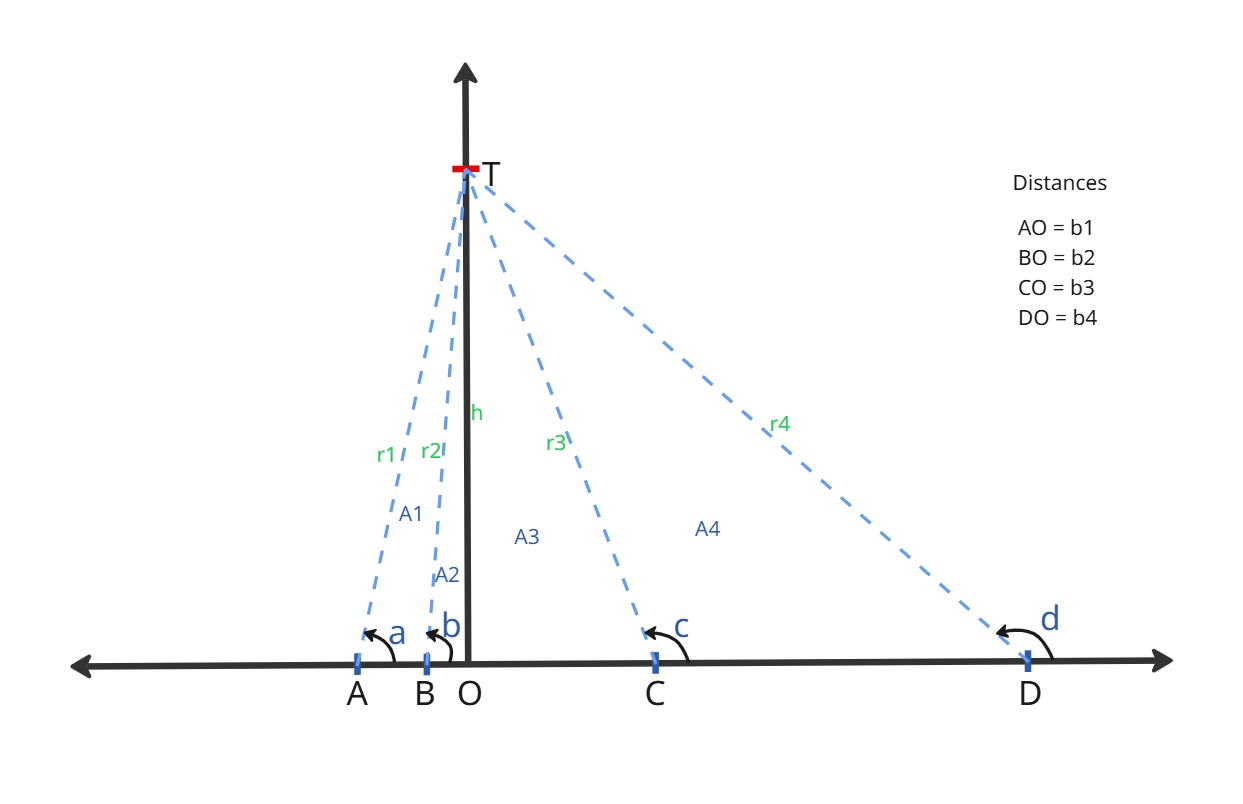

## Parameters to be investigated:

### Single-ray angle $\theta_{k}$
(A ray is just a mapping/projection from an input datapoint to the output datapoint)

$\theta_{k} = \text{arctan}(X_{k}/T)$ where $X_{k}$ is the signed horizontal distance of feature k from O.  

**Stability hypothesis**  
If each feature is roughly a fixed multiple of T (e.g, $X_{k} ≈ \theta_{k}T$ ), then $\theta_{k}$ approaches a constant arctan$(\theta_{k})$.

**For prediction**  
At inference: choose a learned $\hat{\theta_{k}}$ and calculate  $T_{pred} =  X_{k}/\text{tan} \theta_{k}$.  

### Angle ratios $\theta_{i}/\theta_{j}$

Take any two rays/mapping i, j and use the ratio of those angles. In this case we shall investigate all the different combinations.

**Stability hypothesis**  
Products of proportionalities cancel T out entirely, so tiny noise in T or uniform scaling leaves the ratio unchanged.

Gives you a relation(for prediction):  
   
$X_{i}/X_{j} = \text{tan}(\theta_{i})/\text{tan}(\theta_{j})$

### Slope differences  

Let the slope the projection K to target be $m_{k} = T/X_{k}$ and that of another datapoint l be $m_{l}$  
Then take the difference $m_{k} - m_{l}$

**Stability hypothesis**  
For perfect linear relationships the difference is constant; with noise it clusters.

For the different features/parameters, we can take the weighted mean to be the final predicted T



In [ ]:
import pandas as pd
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt

class GeometricRelationsAnalyzer:
    def __init__(self, input_df: pd.DataFrame, target_series: pd.Series):
        self.inputs = input_df
        self.target = target_series
        self.columns = input_df.columns

    def compute_single_ray_angles(self):
        angles_df = self.inputs.divide(self.target, axis=0).apply(np.arctan)
        return angles_df.rename(columns=lambda col: f"angle_{col}")

    def compute_angle_ratios(self, angles_df):
        angle_ratios_data = {}
        for col_i, col_j in permutations(self.columns, 2):
            ratio_col_name = f"{col_i}_over_{col_j}"
            angle_ratios_data[ratio_col_name] = angles_df[f"angle_{col_i}"] / angles_df[f"angle_{col_j}"]
        return pd.DataFrame(angle_ratios_data)

    def compute_slope_differences(self):
        # Broadcasting target over each column of input_df
        slope_df = pd.DataFrame({
            f"slope_{col}": self.target / self.inputs[col]
            for col in self.columns
        })

        slope_diff_data = {}
        for col_i, col_j in permutations(self.columns, 2):
            diff_col_name = f"{col_i}_minus_{col_j}"
            slope_diff_data[diff_col_name] = slope_df[f"slope_{col_i}"] - slope_df[f"slope_{col_j}"]
        return pd.DataFrame(slope_diff_data)

    def analyze(self):
        angles_df = self.compute_single_ray_angles()
        angle_ratios_df = self.compute_angle_ratios(angles_df)
        slope_differences_df = self.compute_slope_differences()
        return angles_df, angle_ratios_df, slope_differences_df



In [ ]:
def generate_geometric_test_data(n_samples=1000, noise_level=0.1, relationship='linear'):
    np.random.seed(42)  # For reproducibility
    X = np.random.uniform(-10, 10, (n_samples, 4))  # 4 input features: A, B, C, D

    if relationship == 'linear':
        y = 1.2 * X[:, 0] - 0.8 * X[:, 1] + 0.5 * X[:, 2] - 1.1 * X[:, 3]
    elif relationship == 'nonlinear':
        y = X[:, 0]**2 - np.exp(X[:, 1] / 5) + np.sin(X[:, 2]) - np.log(np.abs(X[:, 3]) + 1)
    elif relationship == 'periodic':
        y = np.sin(X[:, 0]) + np.cos(X[:, 1]) + np.tan(X[:, 2] / 10) - np.sin(X[:, 3] / 3)
    else:
        raise ValueError("Unknown relationship type. Choose 'linear', 'nonlinear', or 'periodic'.")

    y += noise_level * np.random.randn(n_samples)

    input_df = pd.DataFrame(X, columns=['A', 'B', 'C', 'D'])
    target_series = pd.Series(y, name='T')

    return input_df, target_series

# Generating a sample dataset using a linear relationship
input_df, target_series = generate_geometric_test_data(relationship='linear')

# Instantiating and analysing using the GeometricRelationsAnalyzer
analyzer = GeometricRelationsAnalyzer(input_df, target_series)
angles_df, angle_ratios_df, slope_differences_df = analyzer.analyze()

# Linear data

In [ ]:
input_df.head()

,A,B,C,D
0,-2.509198,9.014286,4.639879,1.973170
1,-6.879627,-6.880110,-8.838328,7.323523
2,2.022300,4.161452,-9.588310,9.398197
3,6.648853,-5.753218,-6.363501,-6.331910
4,-3.915155,0.495129,-1.361100,-4.175417


In [ ]:
print(f"Min value in input_df:\n{input_df.min()}")
print(f"Max value in input_df:\n{input_df.max()}")

Min value in input_df:
A   -9.997306
B   -9.960157
C   -9.999767
D   -9.970524
dtype: float64
Max value in input_df:
A    9.988275
B    9.991154
C    9.977852
D    9.994353
dtype: float64


## Angles_Df

In [ ]:
print("Angles, head:")
angles_df.head()


Angles, head:


,angle_A,angle_B,angle_C,angle_D
0,0.247265,-0.736590,-0.436722,-0.195958
1,0.425139,0.425165,0.526820,-0.449114
2,-0.124991,-0.253011,0.537269,-0.528506
3,0.384953,-0.337200,-0.369927,-0.368252
4,1.266910,-0.383321,0.836846,1.284805


In [ ]:
print("Angles, tail:")
angles_df.tail()

Angles, tail:


,angle_A,angle_B,angle_C,angle_D
995,0.813714,0.771834,-0.720421,-0.717246
996,-1.248430,-1.329350,1.314625,0.440351
997,0.401206,-0.768846,0.827027,0.645999
998,0.335309,-0.554507,-0.010303,-0.079737
999,-0.549005,-0.371387,0.110155,-0.896422


### Angle A

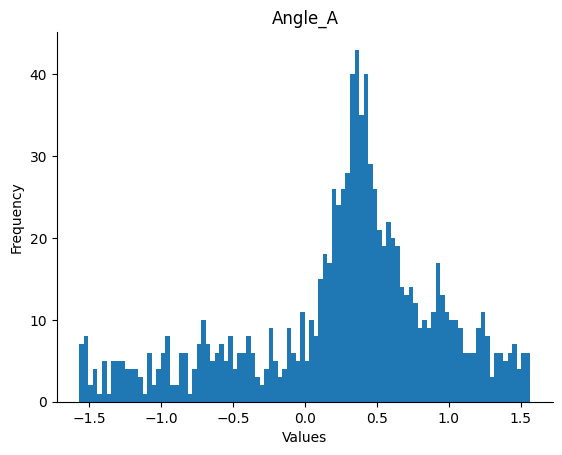

In [ ]:
angles_df['angle_A'].plot(kind='hist',bins=100, title='Angle_A')
plt.gca().spines[['top', 'right',]].set_visible(False)
#plt.title('Histogram of Angle_A')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

Number of values in a given range

In [ ]:
def count_in_range(df, column, lower_bound, upper_bound):
    return df[df[column].between(lower_bound, upper_bound)].shape[0]

In [ ]:
num = count_in_range(angles_df, 'angle_A', 0.1, 0.7)
print(f"Number of values in the range [0.1, 0.7]: {num}")

print(f"Number of values as a percentage: {num/len(angles_df)*100}")

Number of values in the range [0.1, 0.7]: 484
Number of values as a percentage: 48.4


### Angle B

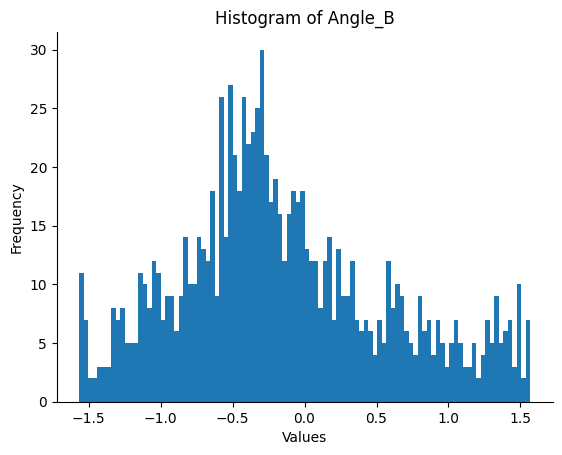

In [ ]:
angles_df['angle_B'].plot(kind='hist',bins=100)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Histogram of Angle_B')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
num2 = count_in_range(angles_df, 'angle_B', -1.7, 0.1)
print(f"Number of values in the range [-1.7, 0.1]: {num2}")

print(f"Number of values as a percentage: {num2/len(angles_df)*100}")

Number of values in the range [-1.7, 0.1]: 684
Number of values as a percentage: 68.4


### Angle C

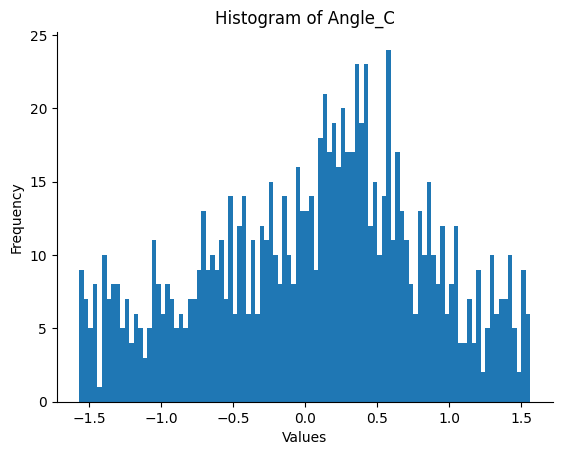

In [ ]:
angles_df['angle_C'].plot(kind='hist',bins=100)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Histogram of Angle_C')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
num3 = count_in_range(angles_df, 'angle_C', 0.0, 0.7)
print(f"Number of values in the range [0.0, 0.7]: {num3}")

print(f"Number of values as a percentage: {num3/len(angles_df)*100}")

Number of values in the range [0.0, 0.7]: 368
Number of values as a percentage: 36.8


### Angle D

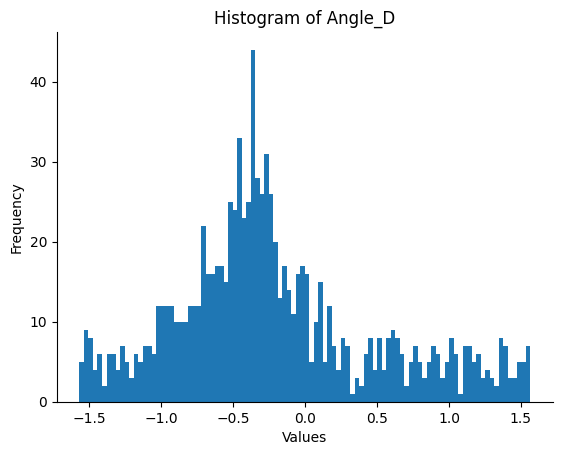

In [ ]:
angles_df['angle_D'].plot(kind='hist',bins=100)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Histogram of Angle_D')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
num4 = count_in_range(angles_df, 'angle_D', -0.9, 0.1)
print(f"Number of values in the range [-0.9, 0.1]: {num4}")

print(f"Number of values as a percentage: {num4/len(angles_df)*100}")

Number of values in the range [-0.9, 0.1]: 592
Number of values as a percentage: 59.199999999999996


In [ ]:
# plotting all the histograms for columns in angles_df in one image using subplots

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# for i, column in enumerate(angles_df.columns):
#     axes[i].hist(angles_df[column], bins=100, edgecolor='black')
#     axes[i].set_xlabel('Values')
#     axes[i].set_ylabel('Frequency')
#     axes[i].set_title(f'Histogram of {column}')
#     axes[i].spines[['top', 'right']].set_visible(False)
#     axes[i].set_xlim(-500, 1000)

# plt.tight_layout()
# plt.show()

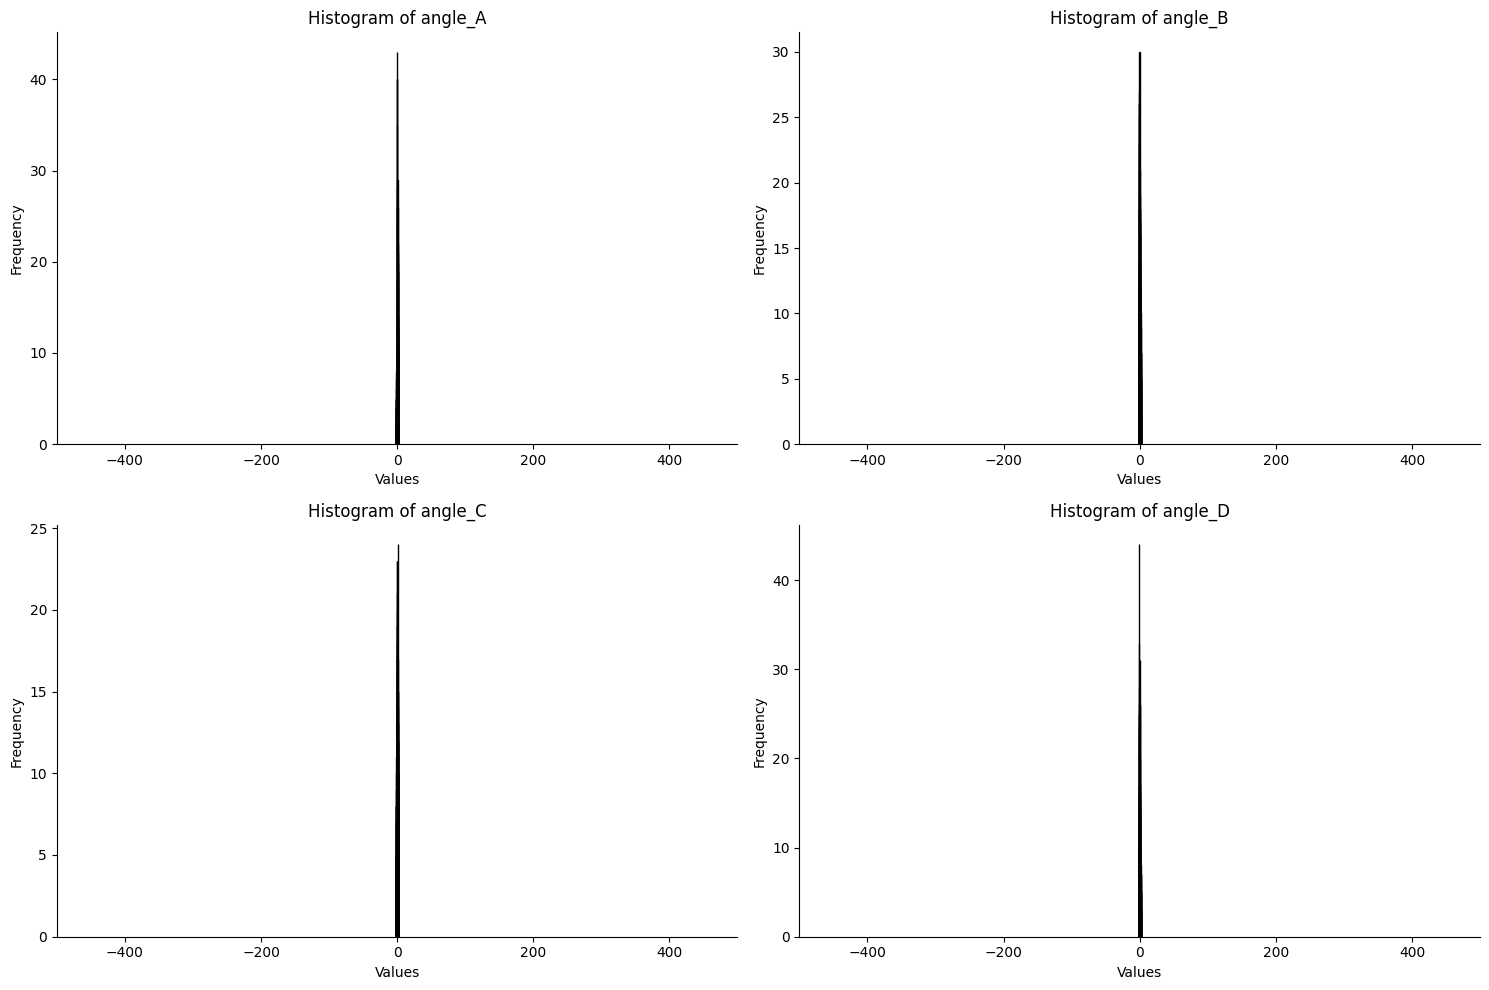

In [ ]:
# plotting all the histograms for columns in angles_df in one image using subplots

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for i, column in enumerate(angles_df.columns):
    # Accessing the correct Axes object using row and column indices
    row = i // 2  # Calculate row index
    col = i % 2   # Calculate column index
    axes[row, col].hist(angles_df[column], bins=100, edgecolor='black')
    axes[row, col].set_xlabel('Values')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'Histogram of {column}')
    axes[row, col].spines[['top', 'right']].set_visible(False)
    axes[row, col].set_xlim(-500, 500)

plt.tight_layout()
plt.show()

In [ ]:
# calculating the mean and standard deviation for all columns in the dataframe angles_df and storing them in a dataframe angle_df_meaan_std

angle_df_mean_std = pd.DataFrame(columns=['Mean', 'Std'])
angle_df_mean_std['Mean'] = angles_df.mean()
angle_df_mean_std['Std'] = angles_df.std()
print(angle_df_mean_std)

             Mean       Std
angle_A  0.264033  0.692359
angle_B -0.145269  0.731549
angle_C  0.068948  0.773896
angle_D -0.206295  0.710670


In [ ]:
# For each column in angle_df, what percentage of values is in 3 standard deviations from the mean. I want to add this data as another column in angle_df_mean_std

for column in angle_df_mean_std.index:
  mean = angle_df_mean_std.loc[column, 'Mean']
  std = angle_df_mean_std.loc[column, 'Std']
  angle_df_mean_std.loc[column, '3 std'] = len(angles_df[column][(angles_df[column] >= mean - 3*std) & (angles_df[column] <= mean + 3*std)])/len(angles_df[column])*100
print(angle_df_mean_std)

             Mean       Std  3 std
angle_A  0.264033  0.692359  100.0
angle_B -0.145269  0.731549  100.0
angle_C  0.068948  0.773896  100.0
angle_D -0.206295  0.710670  100.0


### Angle Ratios

In [ ]:
print("Angle ratios, head:")
angle_ratios_df.head(10)

Angle ratios, head:


,A_over_B,A_over_C,A_over_D,B_over_A,B_over_C,B_over_D,C_over_A,C_over_B,C_over_D,D_over_A,D_over_B,D_over_C
0,-0.335689,-0.566184,-1.261828,-2.978951,1.686636,3.758925,-1.766209,0.592896,2.228652,-0.792501,0.266034,0.448702
1,0.999938,0.806991,-0.946616,1.000062,0.807041,-0.946674,1.239171,1.239095,-1.173019,-1.056395,-1.056329,-0.852501
2,0.494014,-0.232641,0.236499,2.024236,-0.470921,0.478729,-4.298465,-2.123500,-1.016581,4.228354,2.088865,-0.983689
3,-1.141618,-1.040620,-1.045352,-0.875950,0.911531,0.915676,-0.960965,1.097055,1.004547,-0.956615,1.092089,0.995473
4,-3.305091,1.513911,0.986072,-0.302564,-0.458054,-0.298349,0.660541,-2.183148,0.651341,1.014125,-3.351775,1.535295
5,-0.358436,-0.561828,-0.843589,-2.789898,1.567443,2.353528,-1.779904,0.637982,1.501508,-1.185411,0.424894,0.665997
6,-0.172103,0.165171,-3.077550,-5.810464,-0.959721,17.881990,6.054327,-1.041970,-18.632491,-0.324934,0.055922,-0.053670
7,-0.219828,0.860416,-0.292039,-4.549005,-3.914038,1.328486,1.162228,-0.255491,-0.339416,-3.424203,0.752737,-2.946240
8,-0.972428,-0.941595,-1.370740,-1.028354,0.968293,1.409606,-1.062028,1.032745,1.455764,-0.729533,0.709418,0.686924
9,0.656667,-1.044226,2.813015,1.522842,-1.590191,4.283777,-0.957647,-0.628855,-2.693876,0.355491,0.233439,-0.371212


In [ ]:
# Mean and standard deviation
angle_ratios_df_mean_std = pd.DataFrame(columns=['Mean', 'Std'])
angle_ratios_df_mean_std['Mean'] = angle_ratios_df.mean()
angle_ratios_df_mean_std['Std'] = angle_ratios_df.std()
print(angle_ratios_df_mean_std)


              Mean        Std
A_over_B -0.248047   7.584494
A_over_C  1.383933  55.470172
A_over_D -0.202227  21.561202
B_over_A  1.071895  18.438182
B_over_C -2.326893  84.848133
B_over_D -0.481628  17.954455
C_over_A  0.100270  20.430493
C_over_B -0.232611  11.628786
C_over_D  0.617621  22.711739
D_over_A  0.422424  15.698008
D_over_B -0.291179  10.380200
D_over_C -0.442267  25.328657


In [ ]:
# Percentage under 3 standard deviations from the mean
for column in angle_ratios_df_mean_std.index:
  mean = angle_ratios_df_mean_std.loc[column, 'Mean']
  std = angle_ratios_df_mean_std.loc[column, 'Std']
  angle_ratios_df_mean_std.loc[column, '3 std'] = len(angle_ratios_df[column][(angle_ratios_df[column] >= mean - 3*std) & (angle_ratios_df[column] <= mean + 3*std)])/len(angle_ratios_df[column])*100
print(angle_ratios_df_mean_std)

              Mean        Std  3 std
A_over_B -0.248047   7.584494   98.3
A_over_C  1.383933  55.470172   99.9
A_over_D -0.202227  21.561202   99.5
B_over_A  1.071895  18.438182   99.5
B_over_C -2.326893  84.848133   99.9
B_over_D -0.481628  17.954455   99.0
C_over_A  0.100270  20.430493   99.3
C_over_B -0.232611  11.628786   98.9
C_over_D  0.617621  22.711739   99.3
D_over_A  0.422424  15.698008   99.1
D_over_B -0.291179  10.380200   99.0
D_over_C -0.442267  25.328657   99.8


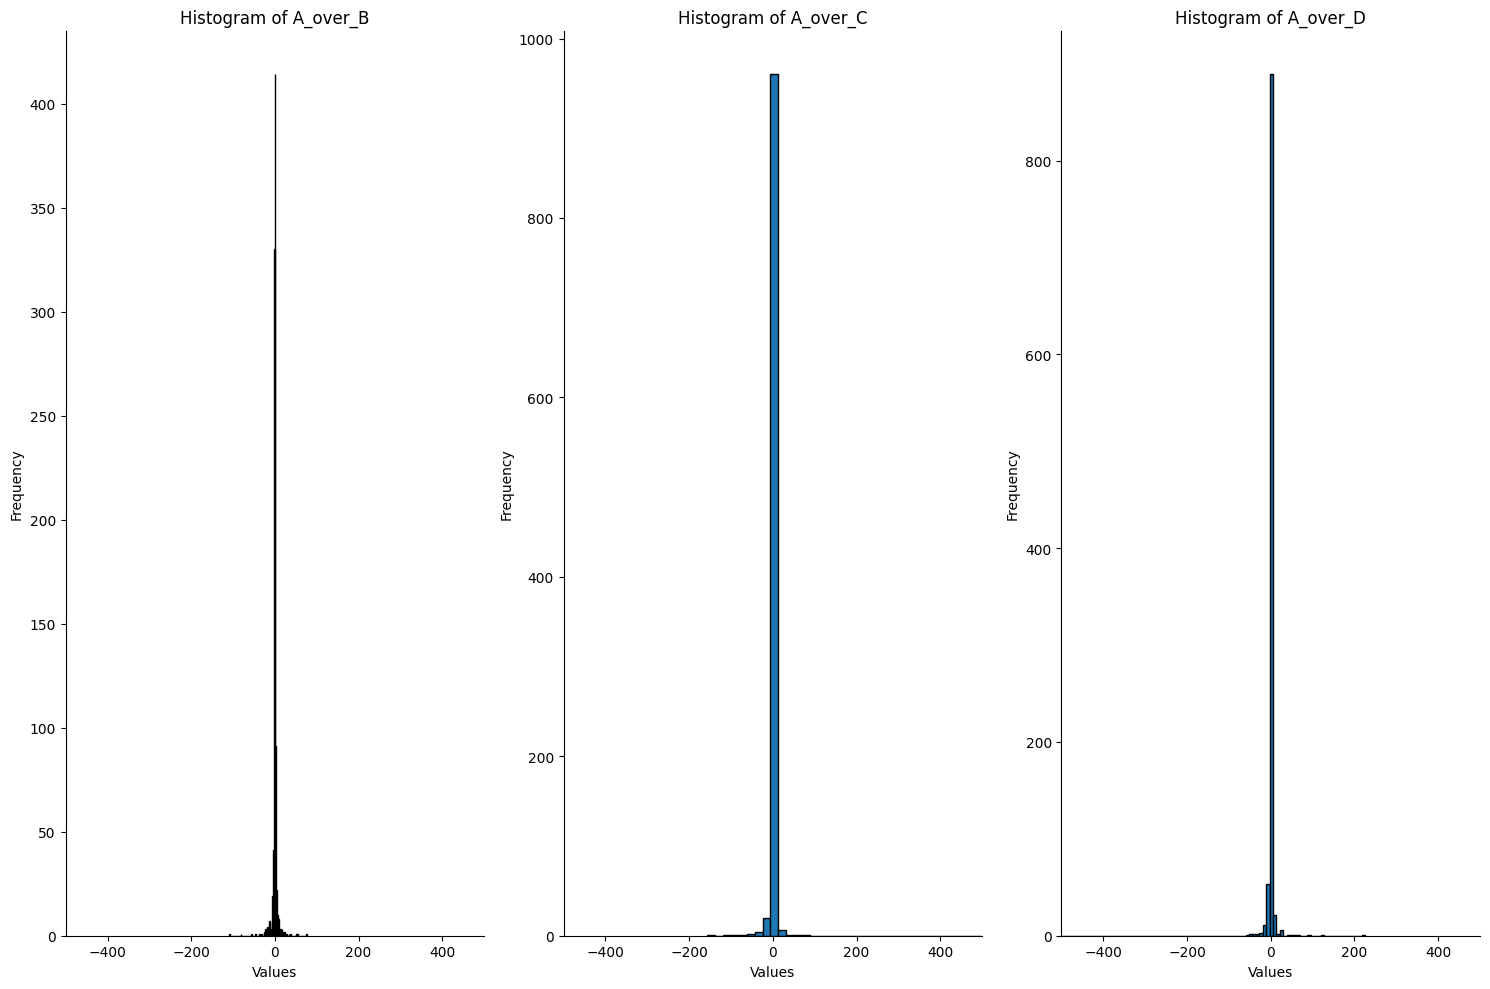

In [ ]:
# plotting subplots for first 3 columns in angle_ratios_df

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

for i in range(3):
  axes[i].hist(angle_ratios_df.iloc[:, i], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_ylabel('Frequency')
  axes[i].set_title(f'Histogram of {angle_ratios_df.columns[i]}')
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-500, 500)

plt.tight_layout()
plt.show()

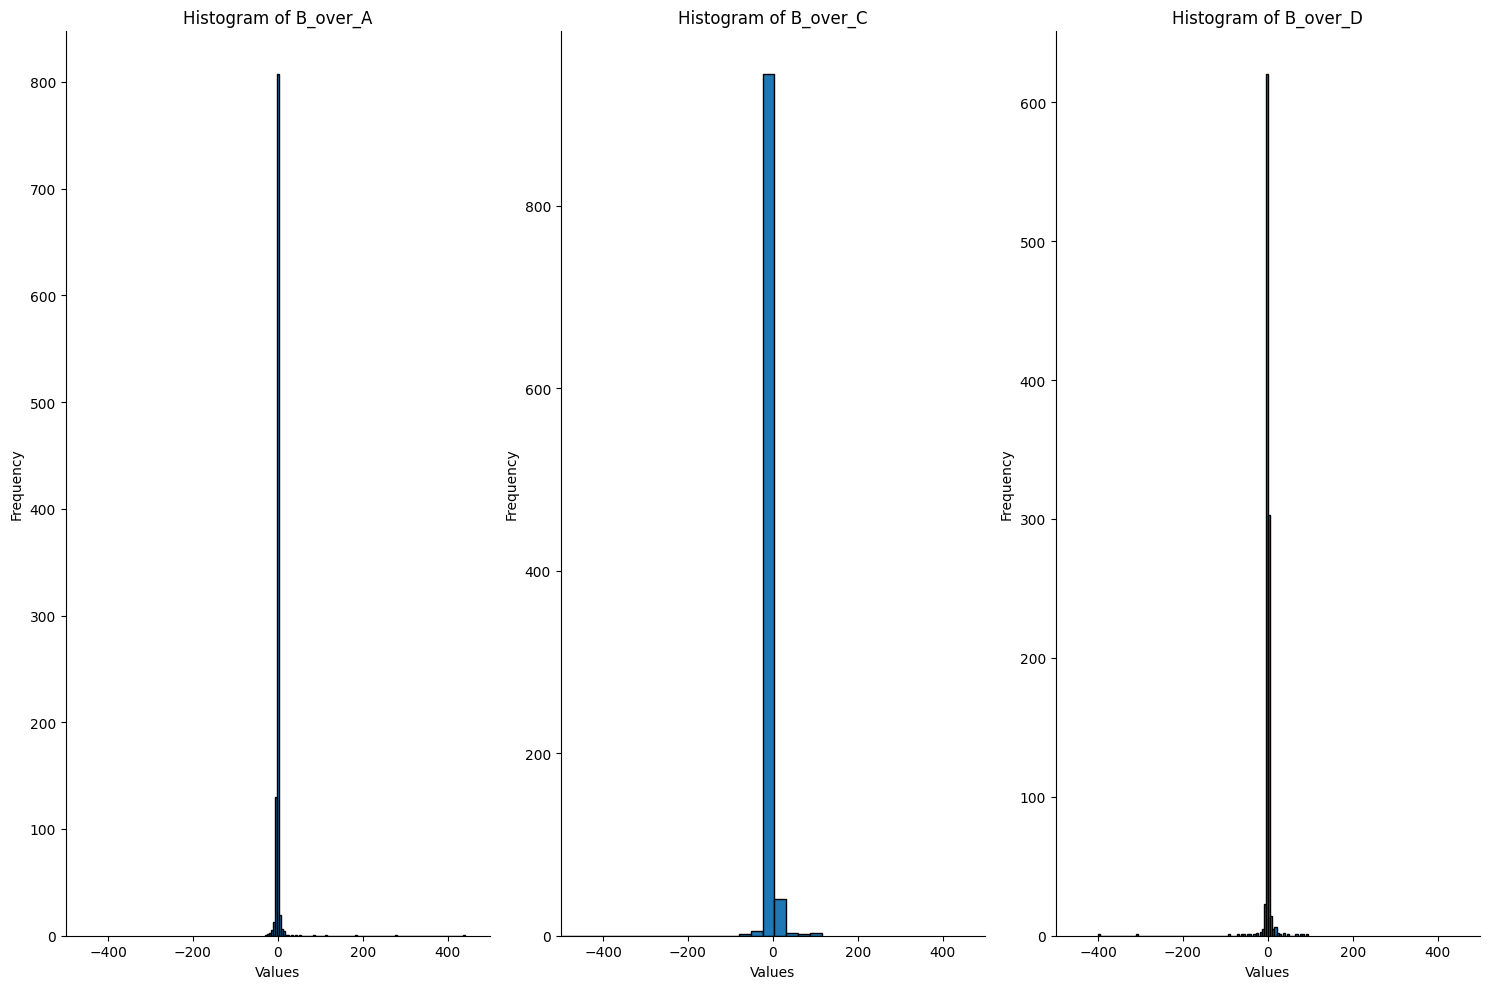

In [ ]:
# plotting subplots for the next 3 columns in angle_ratios_df

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

for i in range(3):
  col = i + 3
  axes[i].hist(angle_ratios_df.iloc[:, col], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_ylabel('Frequency')
  axes[i].set_title(f'Histogram of {angle_ratios_df.columns[col]}')
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-500, 500)

plt.tight_layout()
plt.show()

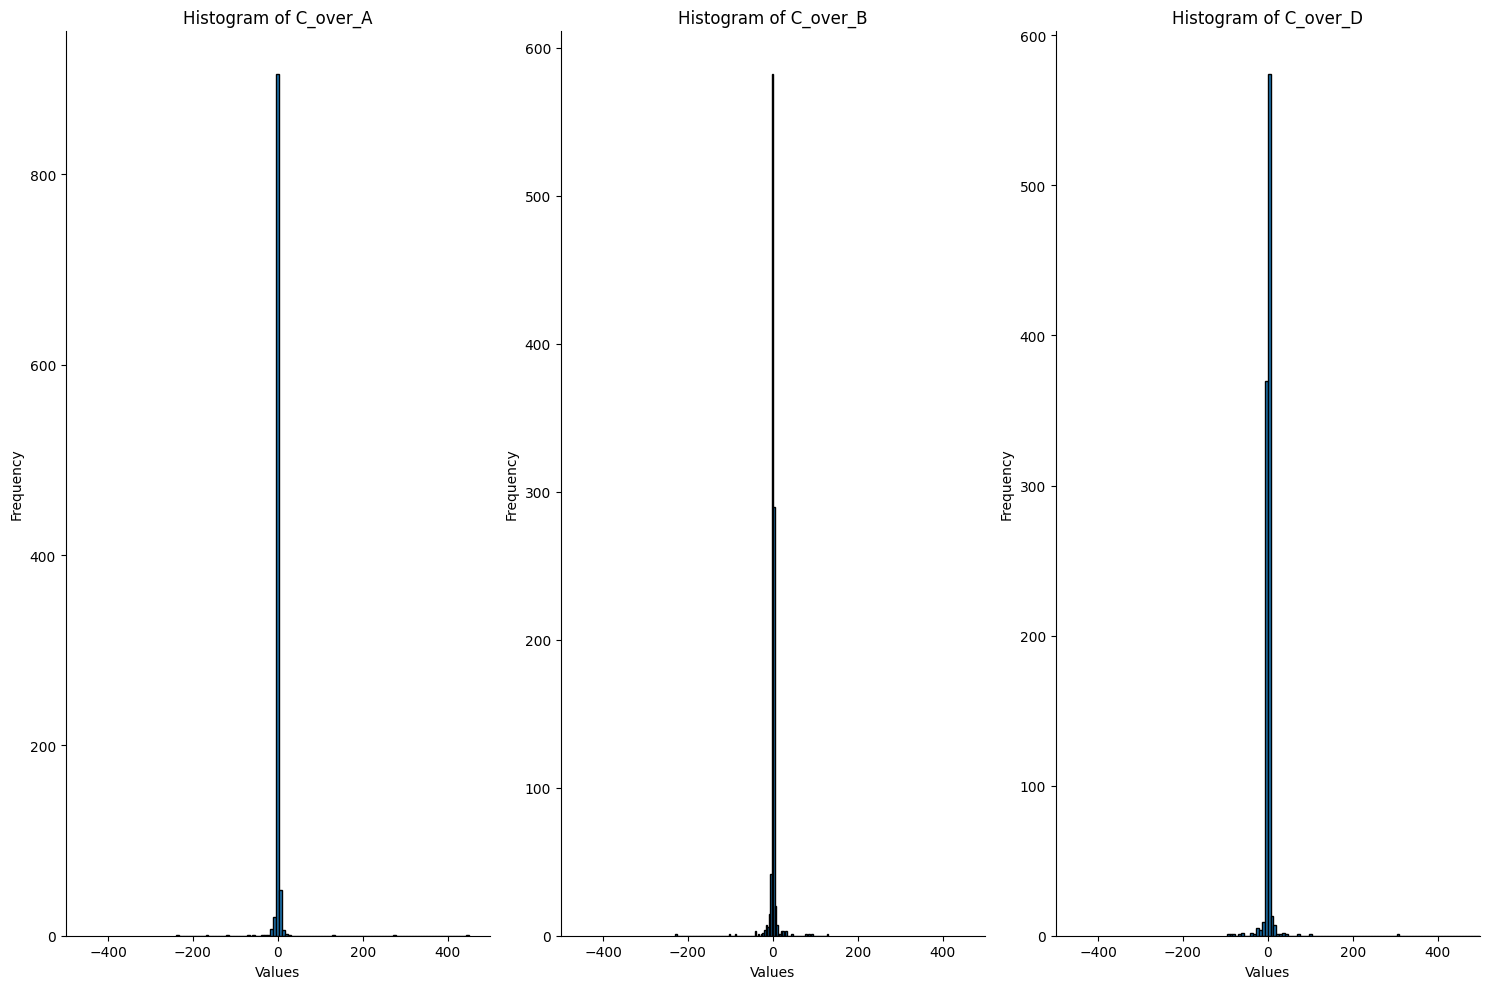

In [ ]:
# plotting subplots for the next 3 columns in angle_ratios_df

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

for i in range(3):
  col = i + 6
  axes[i].hist(angle_ratios_df.iloc[:, col], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_ylabel('Frequency')
  axes[i].set_title(f'Histogram of {angle_ratios_df.columns[col]}')
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-500, 500)

plt.tight_layout()
plt.show()

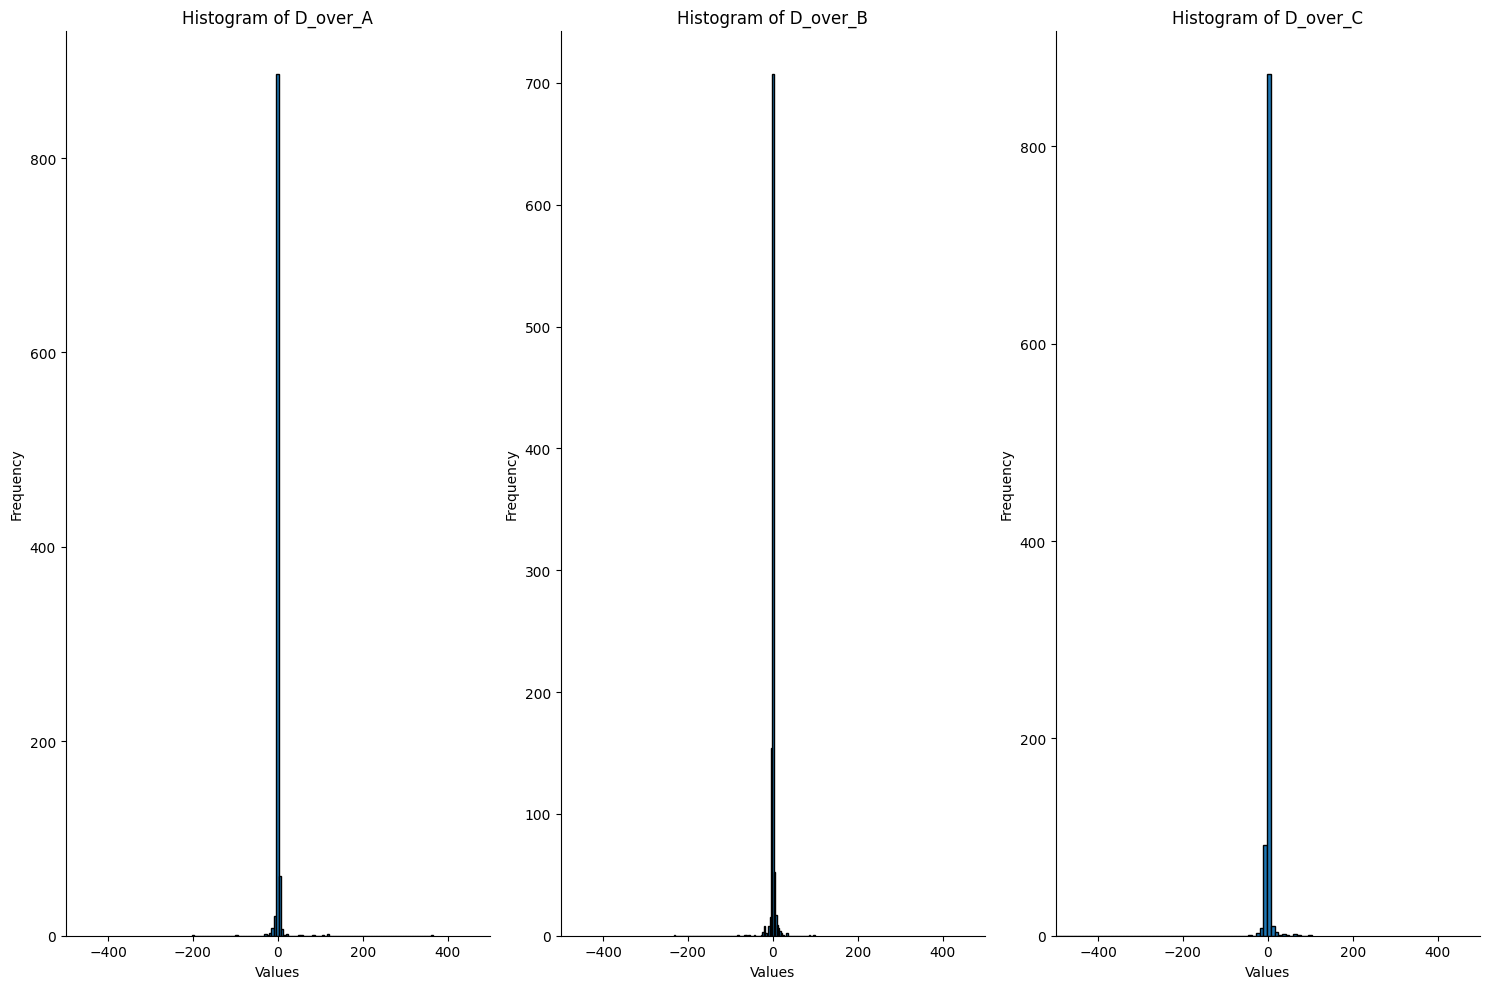

In [ ]:
# plotting subplots for the last 3 columns in angle_ratios_df

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

for i in range(3):
  col = i + 9
  axes[i].hist(angle_ratios_df.iloc[:, col], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_ylabel('Frequency')
  axes[i].set_title(f'Histogram of {angle_ratios_df.columns[col]}')
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-500, 500)

plt.tight_layout()
plt.show()

## Slope Differences

In [ ]:
print("Slope differences, head:")
slope_differences_df.head()

Slope differences, head:


,A_minus_B,A_minus_C,A_minus_D,B_minus_A,B_minus_C,B_minus_D,C_minus_A,C_minus_B,C_minus_D,D_minus_A,D_minus_B,D_minus_C
0,5.064196,6.103815,8.999141,-5.064196,1.039619,3.934945,-6.103815,-1.039619,2.895326,-8.999141,-3.934945,-2.895326
1,0.000155,0.489485,4.283569,-0.000155,0.489330,4.283414,-0.489485,-0.489330,3.794084,-4.283569,-4.283414,-3.794084
2,-4.091175,-9.637499,-6.246283,4.091175,-5.546324,-2.155108,9.637499,5.546324,3.391216,6.246283,2.155108,-3.391216
3,5.320457,5.046907,5.059773,-5.320457,-0.273550,-0.260684,-5.046907,0.273550,0.012866,-5.059773,0.260684,-0.012866
4,2.793337,-0.588458,0.019547,-2.793337,-3.381794,-2.773789,0.588458,3.381794,0.608005,-0.019547,2.773789,-0.608005


In [ ]:
slope_differences_df_mean_std = pd.DataFrame(columns=['Mean', 'Std'])
slope_differences_df_mean_std['Mean'] = slope_differences_df.mean()
slope_differences_df_mean_std['Std'] = slope_differences_df.std()
print("\nMean and standard deviation for each column:")
print(slope_differences_df_mean_std)


Mean and standard deviation for each column:
               Mean         Std
A_minus_B  0.375087   33.090340
A_minus_C -5.153815  173.887753
A_minus_D  0.378036   43.156173
B_minus_A -0.375087   33.090340
B_minus_C -5.528902  172.874109
B_minus_D  0.002949   38.546074
C_minus_A  5.153815  173.887753
C_minus_B  5.528902  172.874109
C_minus_D  5.531851  175.207697
D_minus_A -0.378036   43.156173
D_minus_B -0.002949   38.546074
D_minus_C -5.531851  175.207697


In [ ]:
# For each column in slope_differences_df, what percentage of values is in 3 standard deviations from the mean. I want to add this data as another column in slope_differences_df_mean_std

for column in slope_differences_df_mean_std.index:
  mean = slope_differences_df_mean_std.loc[column, 'Mean']
  std = slope_differences_df_mean_std.loc[column, 'Std']
  slope_differences_df_mean_std.loc[column, '3 std'] = len(slope_differences_df[column][(slope_differences_df[column] >= mean - 3*std) & (slope_differences_df[column] <= mean + 3*std)])/len(slope_differences_df[column])*100
print(slope_differences_df_mean_std)


               Mean         Std  3 std
A_minus_B  0.375087   33.090340   98.2
A_minus_C -5.153815  173.887753   99.8
A_minus_D  0.378036   43.156173   98.9
B_minus_A -0.375087   33.090340   98.2
B_minus_C -5.528902  172.874109   99.9
B_minus_D  0.002949   38.546074   98.8
C_minus_A  5.153815  173.887753   99.8
C_minus_B  5.528902  172.874109   99.9
C_minus_D  5.531851  175.207697   99.8
D_minus_A -0.378036   43.156173   98.9
D_minus_B -0.002949   38.546074   98.8
D_minus_C -5.531851  175.207697   99.8


Probably consider columns with the lowest standard deviation

In [ ]:
# calculate correlation between slope A and slope B , slope A and slope C

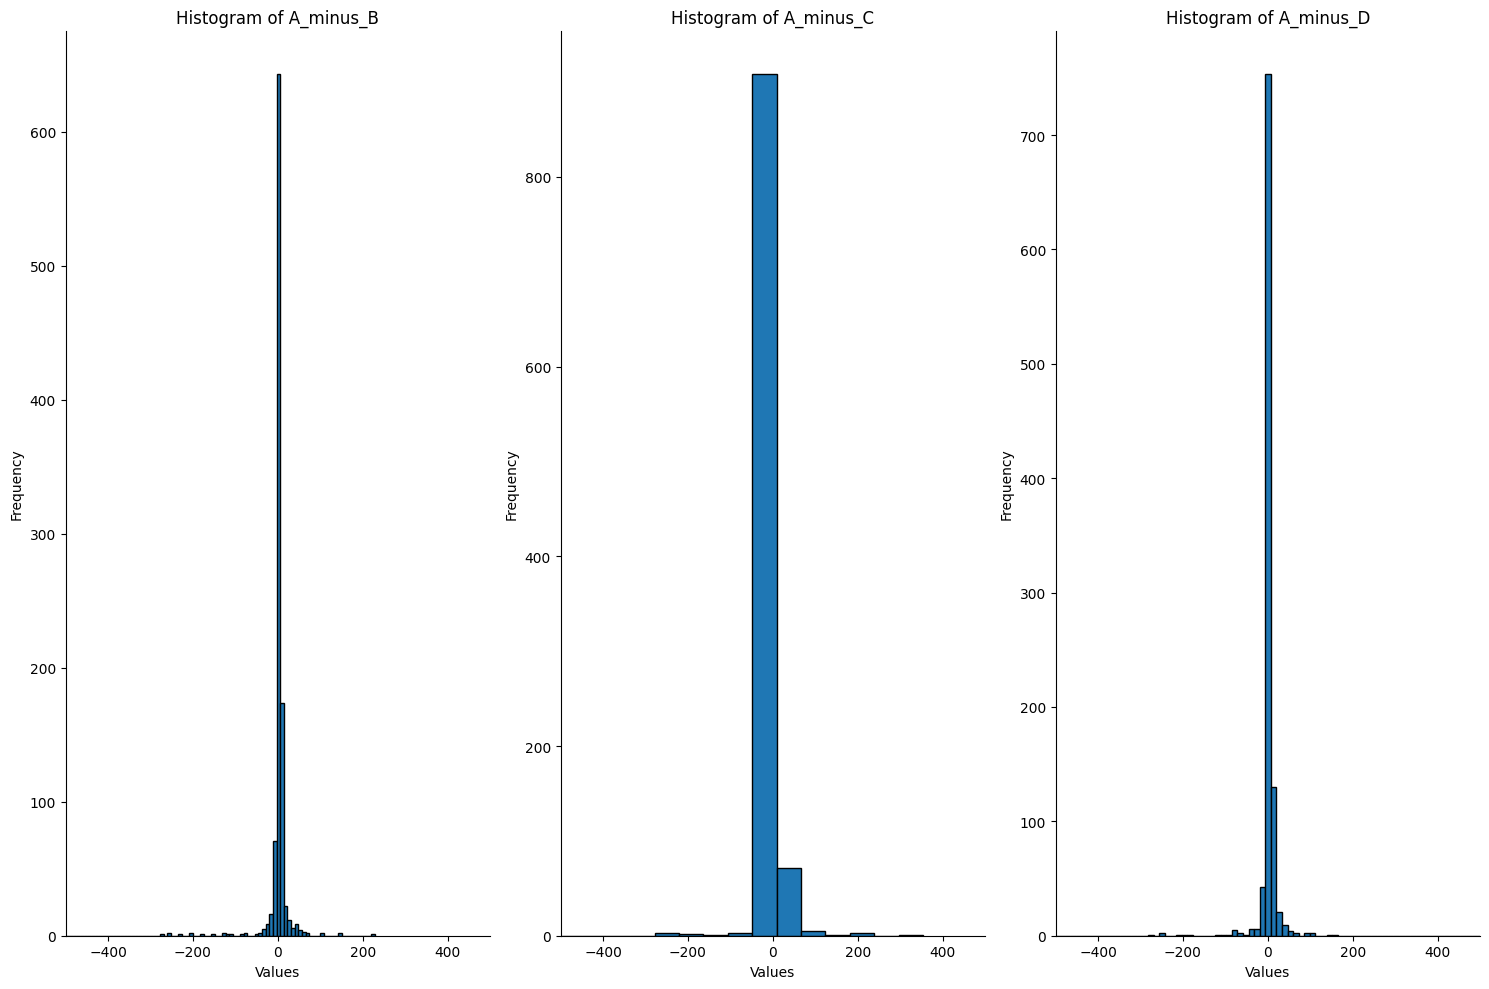

In [ ]:
# plotting histograms for all columns in slope differences_df, 4 seperate plots with 3 subplots each

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

#Plotting histograms for columns 1 to 3 in one plot as subplots using a for loop

for i in range(3):
    axes[i].hist(slope_differences_df.iloc[:, i], bins=100, edgecolor='black')
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {slope_differences_df.columns[i]}')
    axes[i].spines[['top', 'right']].set_visible(False)
    axes[i].set_xlim(-500, 500)

plt.tight_layout()
plt.show()


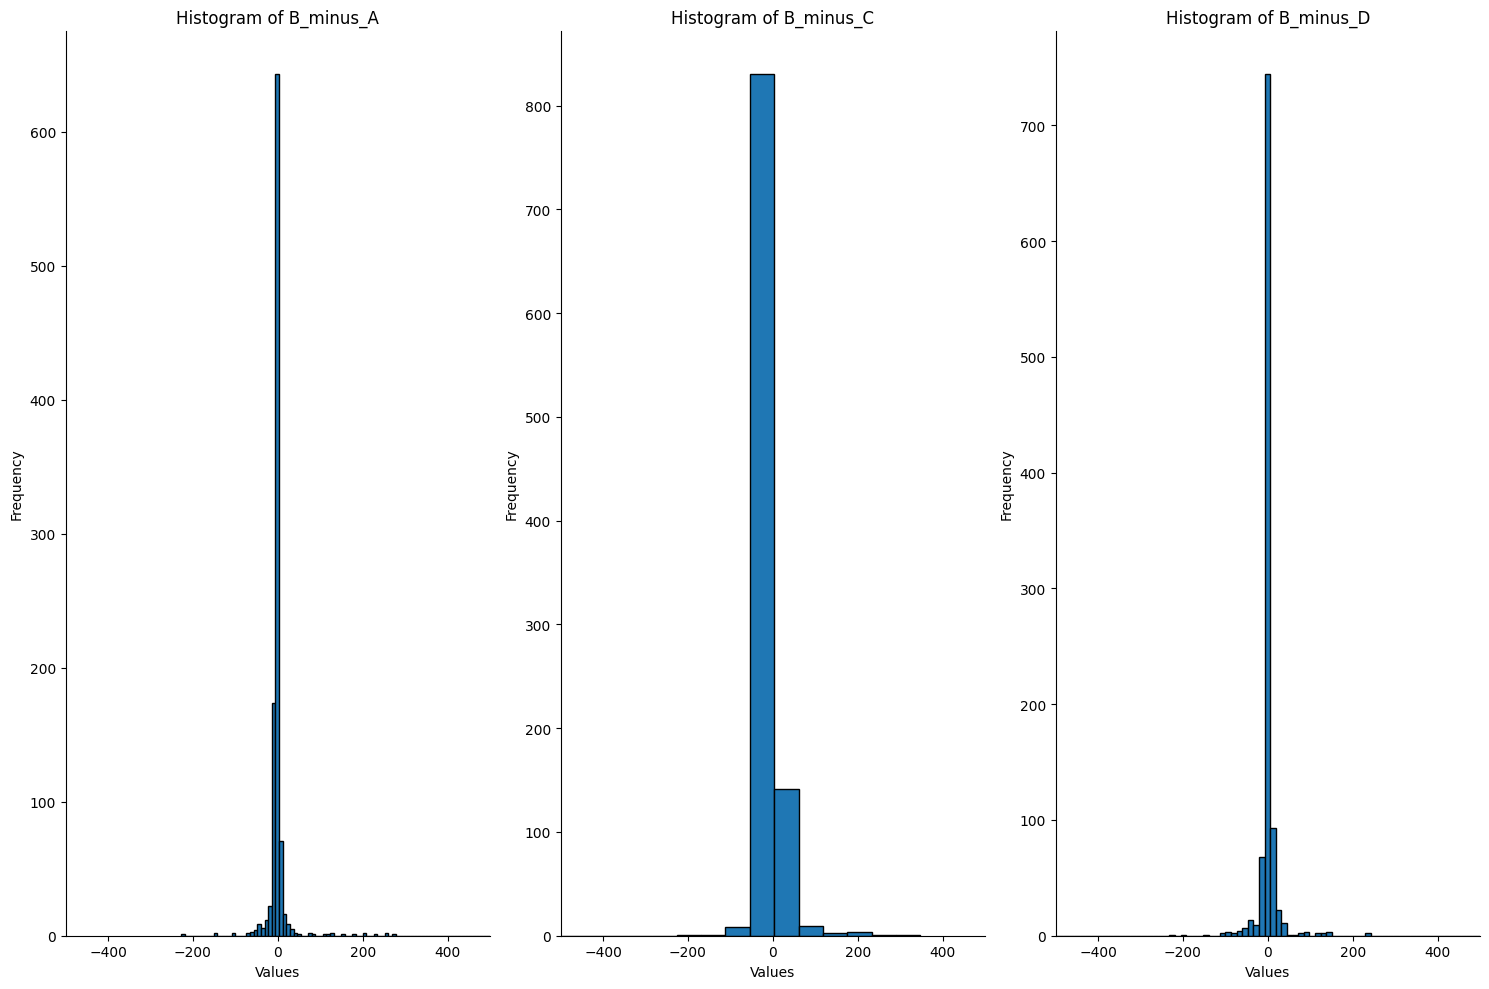

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

#Plotting histograms for columns 4 to 6 in one plot as subplots using a for loop

for i in range(3):
  col = i + 3
  axes[i].hist(slope_differences_df.iloc[:, col], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_ylabel('Frequency')
  axes[i].set_title(f'Histogram of {slope_differences_df.columns[col]}')
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-500, 500)

plt.tight_layout()
plt.show()

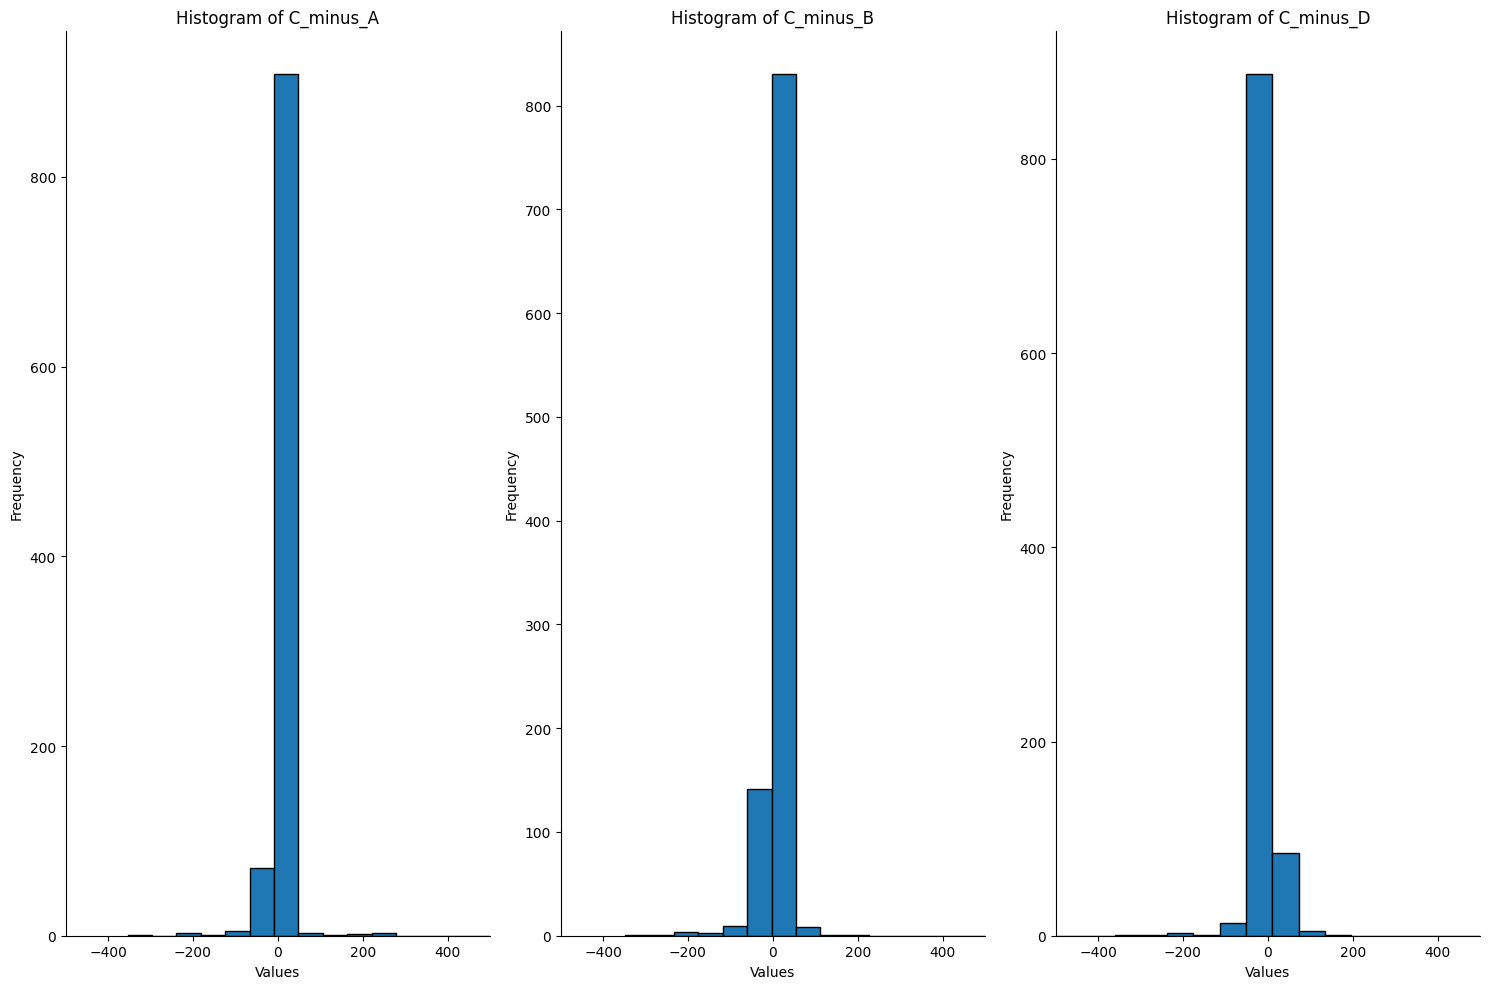

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

#Plotting histograms for columns 7 to 9 in one plot as subplots using a for loop

for i in range(3):
  col = i + 6
  axes[i].hist(slope_differences_df.iloc[:, col], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_ylabel('Frequency')
  axes[i].set_title(f'Histogram of {slope_differences_df.columns[col]}')
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-500, 500)

plt.tight_layout()
plt.show()

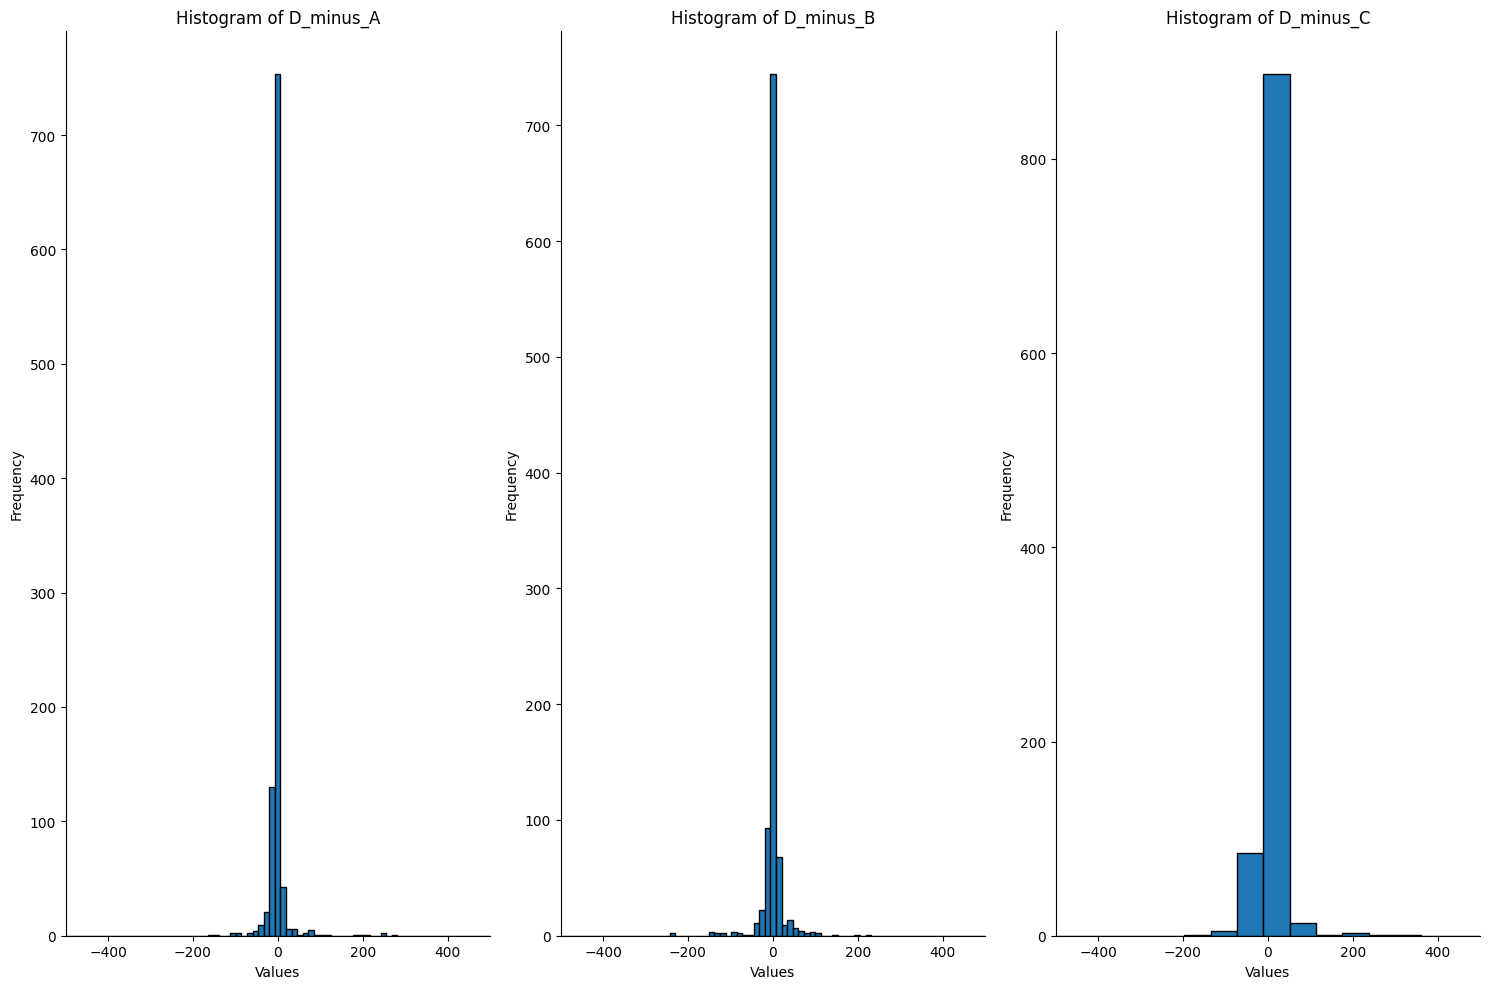

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

#Plotting histograms for columns 10 to 12 in one plot as subplots using a for loop

for i in range(3):
  col = i + 9
  axes[i].hist(slope_differences_df.iloc[:, col], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_ylabel('Frequency')
  axes[i].set_title(f'Histogram of {slope_differences_df.columns[col]}')
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-500, 500)

plt.tight_layout()
plt.show()

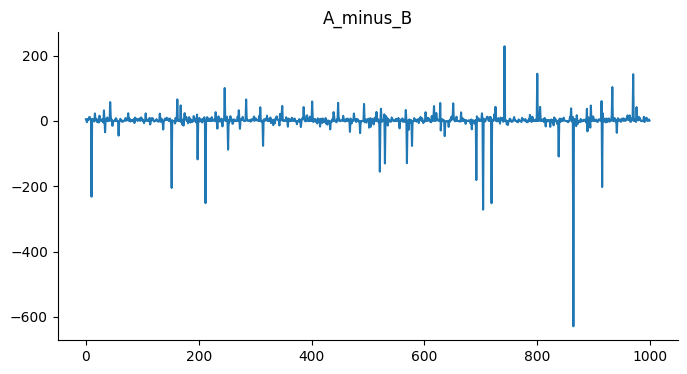

In [ ]:
# @title A_minus_B

from matplotlib import pyplot as plt
slope_differences_df['A_minus_B'].plot(kind='line', figsize=(8, 4), title='A_minus_B')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
print("Angle ratios, tail:")
angle_ratios_df.tail()

Angle ratios, tail:


,A_over_B,A_over_C,A_over_D,B_over_A,B_over_C,B_over_D,C_over_A,C_over_B,C_over_D,D_over_A,D_over_B,D_over_C
995,1.054260,-1.129498,-1.134497,0.948533,-1.071366,-1.076108,-0.885349,-0.933388,1.004427,-0.881448,-0.929275,0.995593
996,0.939128,-0.949647,-2.835081,1.064818,-1.011201,-3.018844,-1.053022,-0.988923,2.985404,-0.352724,-0.331253,0.334963
997,-0.521829,0.485119,0.621063,-1.916336,-0.929650,-1.190166,2.061351,-1.075673,1.280229,1.610142,-0.840219,0.781110
998,-0.604698,-32.545984,-4.205191,-1.653719,53.821906,6.954203,-0.030726,0.018580,0.129208,-0.237801,0.143798,7.739479
999,1.478257,-4.983909,0.612440,0.676472,-3.371477,0.414299,-0.200646,-0.296606,-0.122884,1.632812,2.413716,-8.137786


# Non Linear Data

In [ ]:
# Generating non linear data for a new class object of geometricrelationanalyzer() and analyzing it

input2_df, target2_series = generate_geometric_test_data(relationship='nonlinear')

analyzer2 = GeometricRelationsAnalyzer(input2_df, target2_series)
angles2_df, angle_ratios2_df, slope_differences2_df = analyzer2.analyze()


## Angles2_df

In [ ]:
print("Angles, head:")
angles2_df.head(10)

Angles, head:


,angle_A,angle_B,angle_C,angle_D
0,0.968523,-1.381717,-1.214850,-0.852398
1,-0.153603,-0.153614,-0.196340,0.163344
2,-1.352619,-1.463470,1.524070,-1.523126
3,0.157505,-0.136571,-0.150850,-0.150112
4,-0.326650,0.042818,-0.117239,-0.346712
5,0.484777,-1.038446,-0.774664,-0.561672
6,0.344347,-1.165094,1.183530,-0.115688
7,0.774858,-1.365625,0.850485,-1.291802
8,-0.127695,0.131740,0.136595,0.090786
9,-0.276282,-0.528448,0.261239,-0.086630


In [ ]:
# Mean and standard deviation
angle2_df_mean_std = pd.DataFrame(columns=['Mean', 'Std'])
angle2_df_mean_std['Mean'] = angles2_df.mean()
angle2_df_mean_std['Std'] = angles2_df.std()
print(angle2_df_mean_std)

             Mean       Std
angle_A -0.011608  0.451767
angle_B -0.045763  0.619436
angle_C -0.008823  0.633214
angle_D  0.004401  0.624949


In [ ]:
# min and max values in angles2_df
print(f"Min value in angles2_df:\n{angles2_df.min()}")
print(f"Max value in angles2_df:\n{angles2_df.max()}")

Min value in angles2_df:
angle_A   -1.549179
angle_B   -1.565078
angle_C   -1.566984
angle_D   -1.567368
dtype: float64
Max value in angles2_df:
angle_A    1.562986
angle_B    1.569614
angle_C    1.560751
angle_D    1.561598
dtype: float64


In [ ]:
# percentage under 2 standard deviations from the mean
for column in angle2_df_mean_std.index:
  mean = angle2_df_mean_std.loc[column, 'Mean']
  std = angle2_df_mean_std.loc[column, 'Std']
  angle2_df_mean_std.loc[column, '2 std'] = len(angles2_df[column][(angles2_df[column] >= mean - 2*std) & (angles2_df[column] <= mean + 2*std)])/len(angles2_df[column])*100
print(angle2_df_mean_std)


             Mean       Std  2 std
angle_A -0.011608  0.451767   92.4
angle_B -0.045763  0.619436   89.9
angle_C -0.008823  0.633214   91.0
angle_D  0.004401  0.624949   90.1


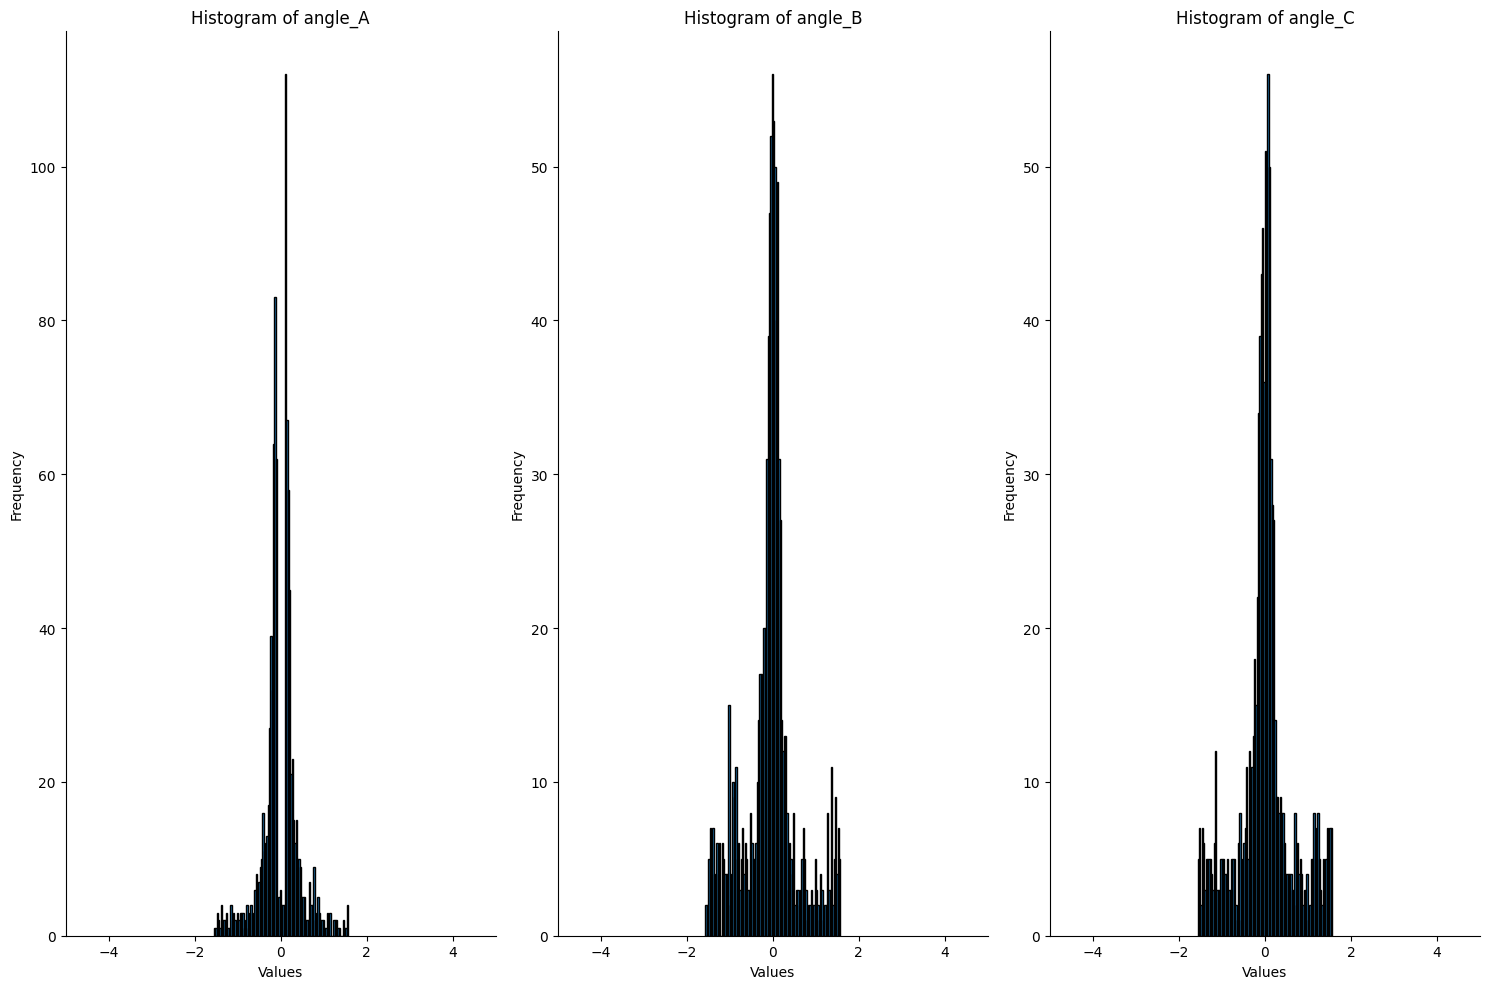

In [ ]:
# histograms for the first 3 columns of angles2_df

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

for i in range(3):
  axes[i].hist(angles2_df.iloc[:, i], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_ylabel('Frequency')
  axes[i].set_title(f'Histogram of {angles2_df.columns[i]}')
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-5, 5)

plt.tight_layout()
plt.show()

## Angle_ratios2

In [ ]:
print("angle_ratios2: head")
angle_ratios2_df.head()

angle_ratios2: head


,A_over_B,A_over_C,A_over_D,B_over_A,B_over_C,B_over_D,C_over_A,C_over_B,C_over_D,D_over_A,D_over_B,D_over_C
0,-0.700956,-0.797237,-1.136234,-1.426623,1.137356,1.620977,-1.254333,0.879232,1.425215,-0.880101,0.616912,0.701648
1,0.999931,0.782333,-0.940366,1.000069,0.782387,-0.940431,1.278228,1.278140,-1.202003,-1.063415,-1.063342,-0.831945
2,0.924255,-0.887505,0.888055,1.081953,-0.960238,0.960833,-1.126755,-1.041408,-1.000620,1.126057,1.040763,-0.999381
3,-1.153282,-1.044119,-1.049250,-0.867090,0.905346,0.909795,-0.957745,1.104550,1.004914,-0.953061,1.099149,0.995110
4,-7.628753,2.786200,0.942136,-0.131083,-0.365224,-0.123498,0.358912,-2.738049,0.338144,1.061418,-8.097296,2.957323


In [ ]:
# put min and max values for each column in a data frame named angle_ratios2_df_min_max

angle_ratios2_df_min_max = pd.DataFrame(columns=['Min', 'Max'])
angle_ratios2_df_min_max['Min'] = angle_ratios2_df.min()
angle_ratios2_df_min_max['Max'] = angle_ratios2_df.max()
print(angle_ratios2_df_min_max)


                  Min          Max
A_over_B  -183.518250    77.855882
A_over_C  -167.388203  1752.226094
A_over_D -1121.698358   240.282111
B_over_A   -41.832877   438.274541
B_over_C -2748.395455   197.179980
B_over_D  -403.309676   269.969846
C_over_A  -410.308801   448.114271
C_over_B  -172.172278   259.145686
C_over_D  -122.385253  1133.973780
D_over_A  -295.865278   364.186289
D_over_B  -173.885470   105.520455
D_over_C  -777.376379   221.120388


In [ ]:
# Mean, standard deviation and percentage of values under 1 standard deviations from the mean

angle_ratios2_df_mean_std = pd.DataFrame(columns=['Mean', 'Std'])
angle_ratios2_df_mean_std['Mean'] = angle_ratios2_df.mean()
angle_ratios2_df_mean_std['Std'] = angle_ratios2_df.std()

for column in angle_ratios2_df_mean_std.index:
  mean = angle_ratios2_df_mean_std.loc[column, 'Mean']
  std = angle_ratios2_df_mean_std.loc[column, 'Std']
  angle_ratios2_df_mean_std.loc[column, '1 std'] = len(angle_ratios2_df[column][(angle_ratios2_df[column] >= mean - 1*std) & (angle_ratios2_df[column] <= mean + 1*std)])/len(angle_ratios2_df[column])*100

print(angle_ratios2_df_mean_std)


              Mean        Std  1 std
A_over_B -0.366174  10.801071   94.2
A_over_C  1.605255  56.862306   99.2
A_over_D -0.430984  38.220425   98.5
B_over_A  0.842162  16.769204   98.7
B_over_C -2.464379  87.678252   99.5
B_over_D -0.362956  21.160374   97.6
C_over_A -0.130332  20.296710   98.5
C_over_B  0.028640  12.792270   95.8
C_over_D  1.136357  38.181009   98.5
D_over_A  0.234647  15.886622   98.4
D_over_B -0.382893  10.412280   95.3
D_over_C -0.231478  26.174569   98.9


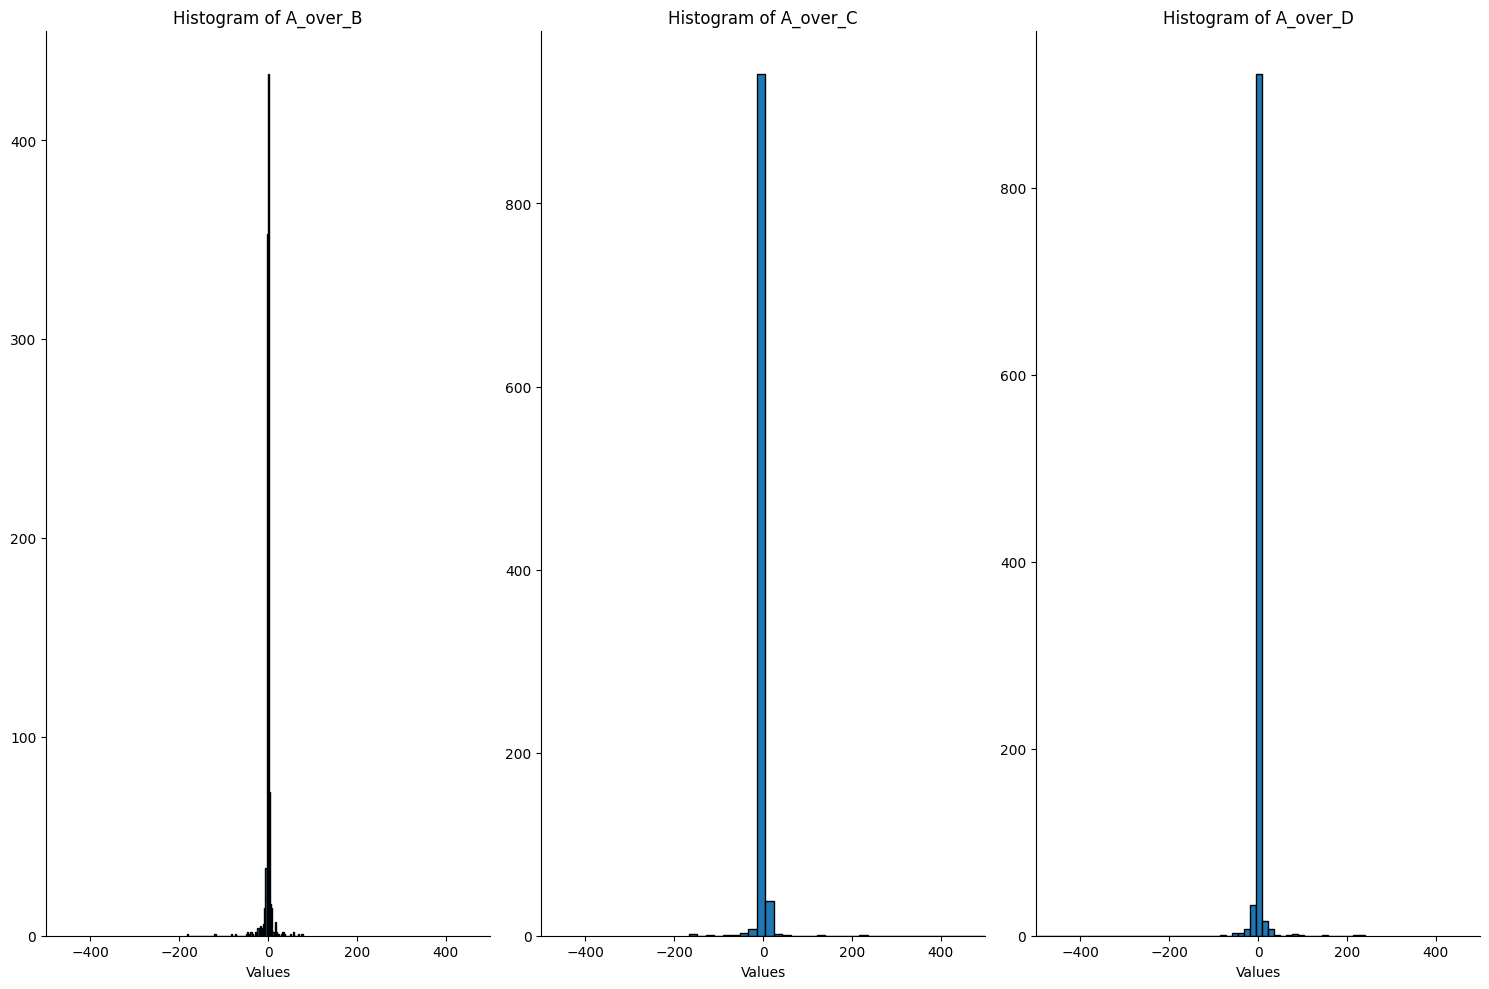

In [ ]:
# Histogram of the first 3 columns of the angle_ratios2_df

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

for i in range(3):
  axes[i].hist(angle_ratios2_df.iloc[:, i], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_title(f"Histogram of {angle_ratios2_df.columns[i]}")
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-500, 500)

plt.tight_layout()
plt.show()

## slope_differences2_df

In [ ]:
print("slope_differences2: head")

slope_differences2_df.head()

slope_differences2: head


,A_minus_B,A_minus_C,A_minus_D,B_minus_A,B_minus_C,B_minus_D,C_minus_A,C_minus_B,C_minus_D,D_minus_A,D_minus_B,D_minus_C
0,0.878845,1.059261,1.561718,-0.878845,0.180416,0.682874,-1.059261,-0.180416,0.502457,-1.561718,-0.682874,-0.502457
1,-0.000453,-1.431407,-12.526506,0.000453,-1.430954,-12.526053,1.431407,1.430954,-11.095098,12.526506,12.526053,11.095098
2,-0.113966,-0.268468,-0.174000,0.113966,-0.154501,-0.060034,0.268468,0.154501,0.094468,0.174000,0.060034,-0.094468
3,13.573027,12.875174,12.907996,-13.573027,-0.697854,-0.665031,-12.875174,0.697854,0.032822,-12.907996,0.665031,-0.032822
4,-26.291957,5.538789,-0.183986,26.291957,31.830746,26.107970,-5.538789,-31.830746,-5.722775,0.183986,-26.107970,5.722775


In [ ]:
# Mean, standard deviation and percentage of values under 1 standard deviations from the mean

slope_differences2_df_mean_std = pd.DataFrame(columns=['Mean', 'Std'])
slope_differences2_df_mean_std['Mean'] = slope_differences2_df.mean()
slope_differences2_df_mean_std['Std'] = slope_differences2_df.std()

for column in slope_differences2_df_mean_std.index:
  mean = slope_differences2_df_mean_std.loc[column, 'Mean']
  std = slope_differences2_df_mean_std.loc[column, 'Std']
  slope_differences2_df_mean_std.loc[column, '1 std'] = len(slope_differences2_df[column][(slope_differences2_df[column] >= mean - 1*std) & (slope_differences2_df[column] <= mean + 1*std)])/len(slope_differences2_df[column])*100
print(slope_differences2_df_mean_std)
#

                Mean         Std  1 std
A_minus_B   3.238090   75.567809   93.7
A_minus_C  -6.272711  234.123678   98.7
A_minus_D -13.401181  333.398767   98.7
B_minus_A  -3.238090   75.567809   93.7
B_minus_C  -9.510801  243.462172   97.2
B_minus_D -16.639271  340.934729   97.9
C_minus_A   6.272711  234.123678   98.7
C_minus_B   9.510801  243.462172   97.2
C_minus_D  -7.128470  405.130613   98.3
D_minus_A  13.401181  333.398767   98.7
D_minus_B  16.639271  340.934729   97.9
D_minus_C   7.128470  405.130613   98.3


In [ ]:
# put min and max values for each column in a data frame named slope_differences2_df_min_max

slope_differences2_df_min_max = pd.DataFrame(columns=['Min', 'Max'])
slope_differences2_df_min_max['Min'] = slope_differences2_df.min()
slope_differences2_df_min_max['Max'] = slope_differences2_df.max()
print(slope_differences2_df_min_max)

                    Min           Max
A_minus_B   -614.869165   1026.708676
A_minus_C  -6733.169854   1532.935604
A_minus_D -10135.163678    833.568217
B_minus_A  -1026.708676    614.869165
B_minus_C  -6739.241247   1532.167209
B_minus_D -10155.198350    839.089289
C_minus_A  -1532.935604   6733.169854
C_minus_B  -1532.167209   6739.241247
C_minus_D -10117.280642   6745.555284
D_minus_A   -833.568217  10135.163678
D_minus_B   -839.089289  10155.198350
D_minus_C  -6745.555284  10117.280642


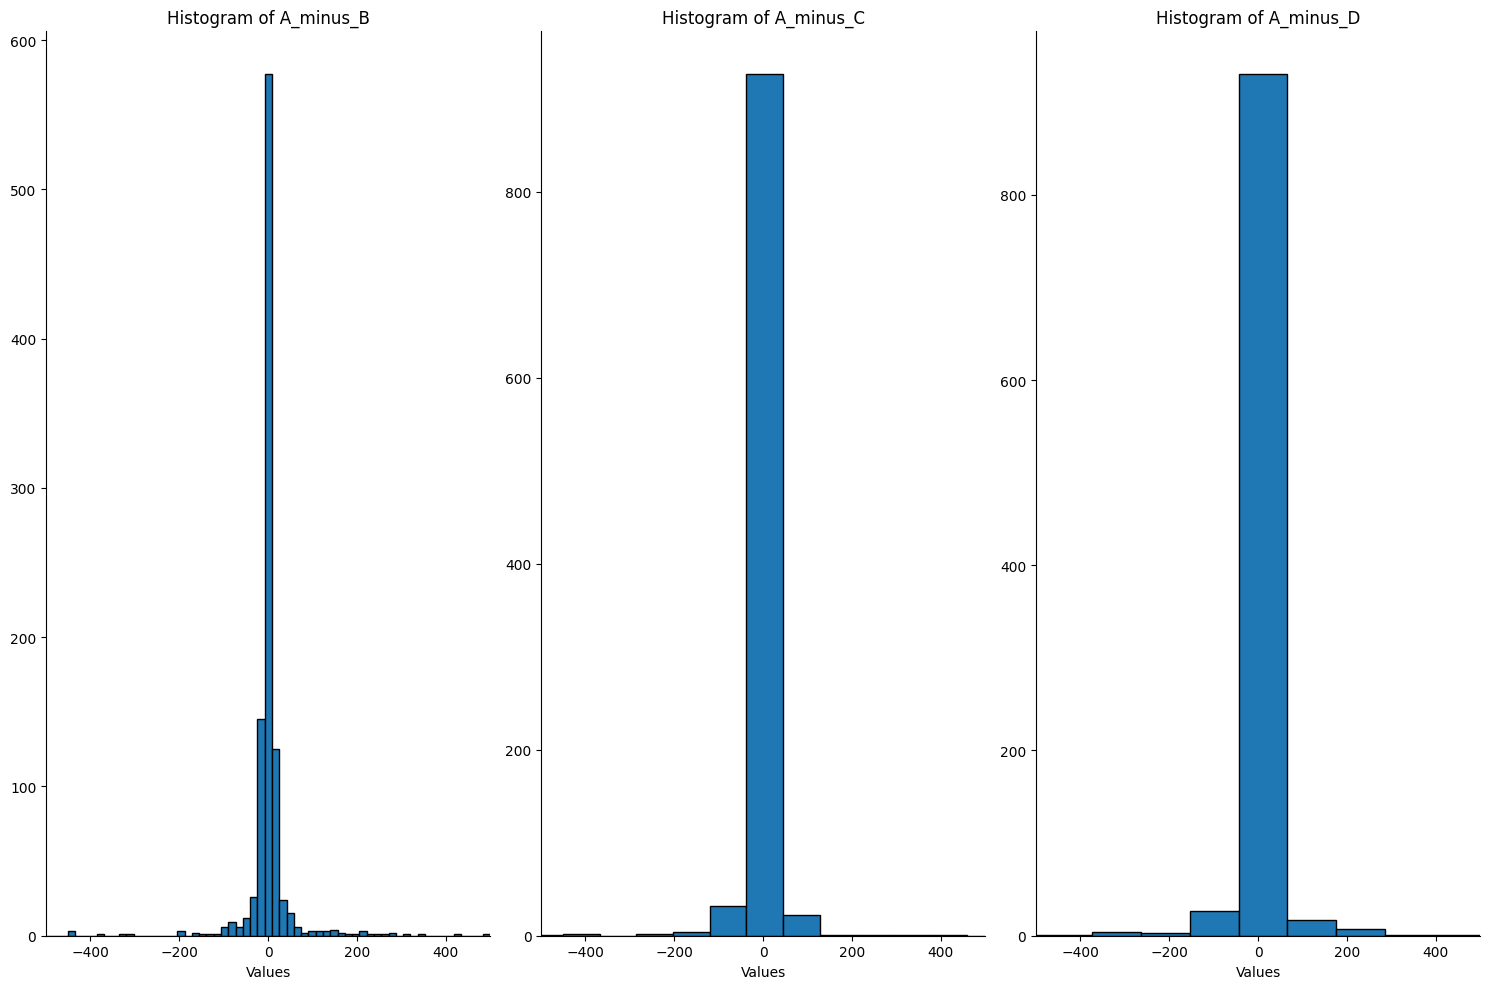

In [ ]:
# Histogram of the first 3 columns of the angle_ratios2_df

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

for i in range(3):
  axes[i].hist(slope_differences2_df.iloc[:, i], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_title(f"Histogram of {slope_differences2_df.columns[i]}")
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-500, 500)

plt.tight_layout()
plt.show()

# Periodic data

In [ ]:
# Generate periodic data from generate_geometric_test_data() and analyze it with GeometricRelationsAnalyzer

input3_df, target3_series = generate_geometric_test_data(relationship='periodic')

analyzer3 = GeometricRelationsAnalyzer(input3_df, target3_series)
angles3_df, angle_ratios3_df, slope_differences3_df = analyzer3.analyze()

In [ ]:
# Min and max values for each column of input3_df in a data frame

input3_df_min_max = pd.DataFrame(columns=['Min', 'Max'])
input3_df_min_max['Min'] = input3_df.min()
input3_df_min_max['Max'] = input3_df.max()
print(input3_df_min_max)

        Min       Max
A -9.997306  9.988275
B -9.960157  9.991154
C -9.999767  9.977852
D -9.970524  9.994353


## Angles3_df

In [ ]:
print("Angles, head:")
angles3_df.head(10)

Angles, head:


,angle_A,angle_B,angle_C,angle_D
0,1.036107,-1.407413,-1.260845,-0.925303
1,1.346843,1.346858,1.395324,-1.360006
2,-1.065773,-1.308334,1.454719,-1.452392
3,1.365442,-1.334574,-1.356507,-1.355471
4,-1.024638,0.205132,-0.519539,-1.052770
5,0.934375,-1.345407,-1.192296,-1.016865
6,0.814746,-1.426547,1.433730,-0.330985
7,1.127537,-1.474358,1.183434,-1.438408
8,1.439966,-1.443984,-1.448499,-1.387307
9,-1.251402,-1.411547,1.233464,-0.747092


In [ ]:
# Mean, standard deviation and percentage of values under 1 standard deviations from the mean

angle3_df_mean_std = pd.DataFrame(columns=['Mean', 'Std'])
angle3_df_mean_std['Mean'] = angles3_df.mean()
angle3_df_mean_std['Std'] = angles3_df.std()

for column in angle3_df_mean_std.index:
  mean = angle3_df_mean_std.loc[column, 'Mean']
  std = angle3_df_mean_std.loc[column, 'Std']
  angle3_df_mean_std.loc[column, '1 std'] = len(angles3_df[column][(angles3_df[column] >= mean - 1*std) & (angles3_df[column] <= mean + 1*std)])/len(angles3_df[column])*100
print(angle3_df_mean_std)


             Mean       Std  1 std
angle_A  0.116976  1.299771   43.0
angle_B  0.006376  1.286488   39.0
angle_C  0.453761  1.231912   71.2
angle_D -0.404558  1.220298   70.9


In [ ]:
# put min and max values for each column in a data frame

angle3_df_min_max = pd.DataFrame(columns=['Min', 'Max'])
angle3_df_min_max['Min'] = angles3_df.min()
angle3_df_min_max['Max'] = angles3_df.max()
print(angle3_df_min_max)


              Min       Max
angle_A -1.570565  1.570736
angle_B -1.570455  1.570281
angle_C -1.570735  1.570524
angle_D -1.570498  1.570687


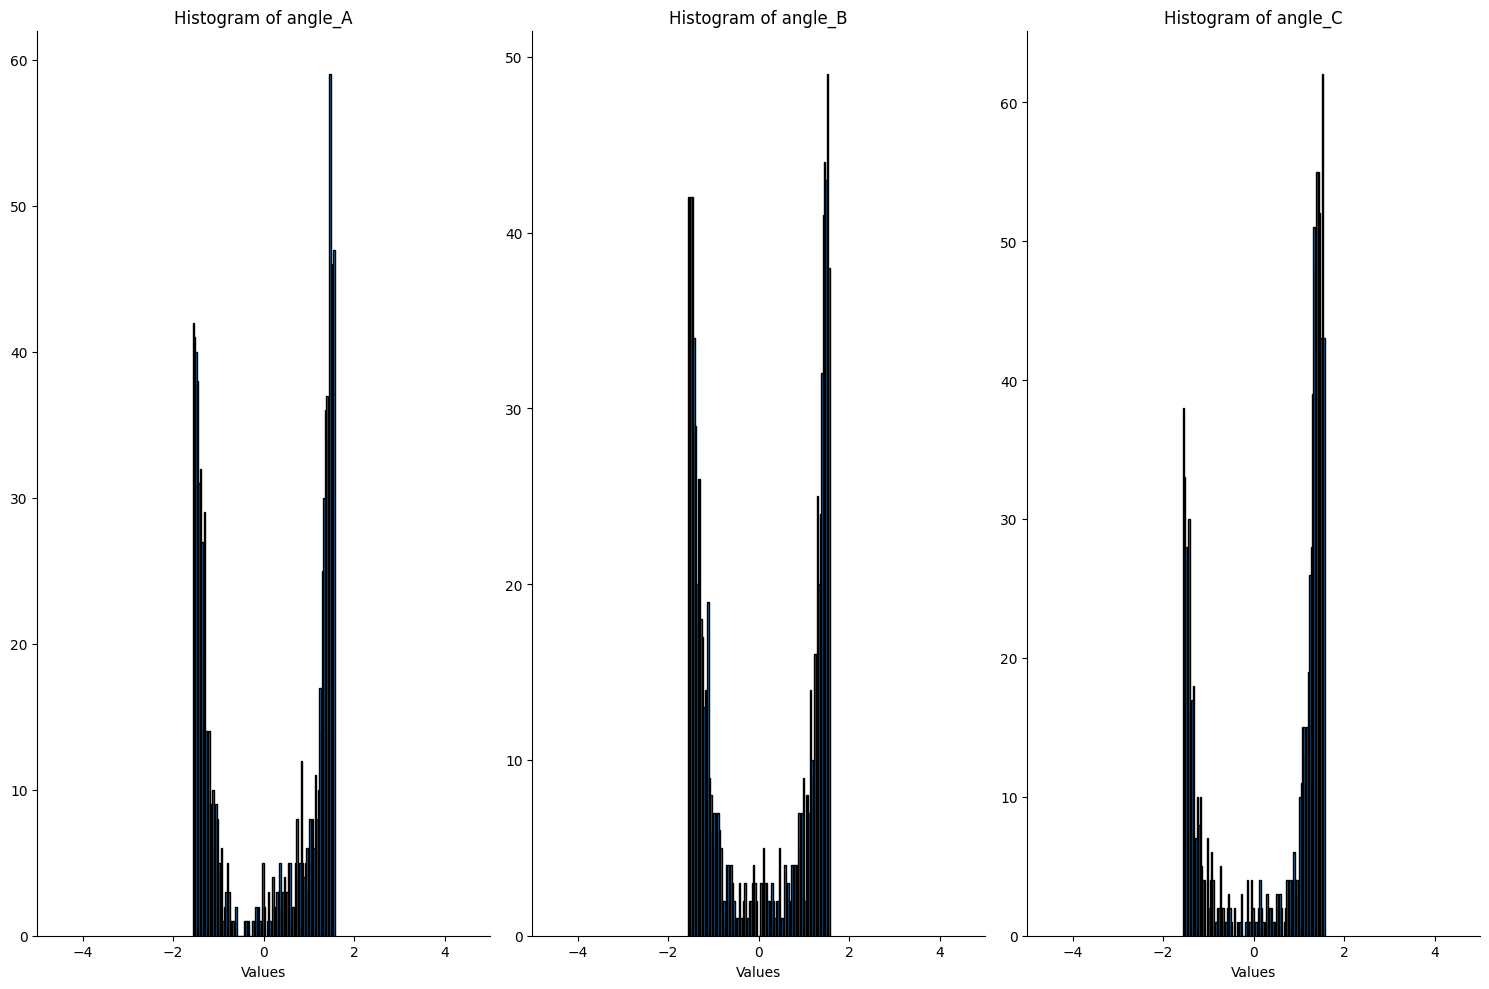

In [ ]:
# Histogram of the first 3 columns of the angles3_df

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

for i in range(3):
  axes[i].hist(angles3_df.iloc[:, i], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_title(f"Histogram of {angles3_df.columns[i]}")
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-5, 5)

plt.tight_layout()
plt.show()

## Angle_ratios3_df

In [ ]:
print("angle_ratios3: head")
angle_ratios3_df.head()

angle_ratios3: head


,A_over_B,A_over_C,A_over_D,B_over_A,B_over_C,B_over_D,C_over_A,C_over_B,C_over_D,D_over_A,D_over_B,D_over_C
0,-0.736179,-0.821756,-1.119750,-1.358366,1.116246,1.521030,-1.216906,0.895860,1.362630,-0.893057,0.657449,0.733875
1,0.999989,0.965255,-0.990321,1.000011,0.965266,-0.990332,1.035996,1.035984,-1.025968,-1.009774,-1.009762,-0.974689
2,0.814603,-0.732632,0.733805,1.227592,-0.899373,0.900813,-1.364942,-1.111886,-1.001602,1.362759,1.110108,-0.998401
3,-1.023129,-1.006587,-1.007356,-0.977394,0.983831,0.984584,-0.993456,1.016434,1.000765,-0.992697,1.015658,0.999236
4,-4.995015,1.972207,0.973278,-0.200200,-0.394835,-0.194850,0.507046,-2.532703,0.493497,1.027455,-5.132154,2.026355


In [ ]:
# Mean, standard deviation and percentage of values under 1 standard deviation from the mean

angle_ratios3_df_mean_std = pd.DataFrame(columns=['Mean', 'Std'])
angle_ratios3_df_mean_std['Mean'] = angle_ratios3_df.mean()
angle_ratios3_df_mean_std['Std'] = angle_ratios3_df.std()

for column in angle_ratios3_df_mean_std.index:
  mean = angle_ratios3_df_mean_std.loc[column, 'Mean']
  std = angle_ratios3_df_mean_std.loc[column, 'Std']
  angle_ratios3_df_mean_std.loc[column, '1 std'] = len(angle_ratios3_df[column][(angle_ratios3_df[column] >= mean - 1*std) & (angle_ratios3_df[column] <= mean + 1*std)])/len(angle_ratios3_df[column])*100
print(angle_ratios3_df_mean_std)


              Mean        Std  1 std
A_over_B -0.025260   3.071249   94.8
A_over_C  0.499708  16.764244   99.2
A_over_D  0.090145   3.611297   96.2
B_over_A  0.596185   9.478672   98.5
B_over_C -0.555023  17.724698   99.3
B_over_D -0.158408   5.739464   97.8
C_over_A  0.082429  10.007021   98.6
C_over_B -0.017677   2.979501   94.7
C_over_D -0.204267   6.321013   97.7
D_over_A  0.288946   9.109695   98.6
D_over_B  0.005599   2.725541   94.5
D_over_C -0.216418  13.967382   99.1


In [ ]:
# put min and max values for each column in a data frame

angle_ratios3_df_min_max = pd.DataFrame(columns=['Min', 'Max'])
angle_ratios3_df_min_max['Min'] = angle_ratios3_df.min()
angle_ratios3_df_min_max['Max'] = angle_ratios3_df.max()
print(angle_ratios3_df_min_max)

                 Min         Max
A_over_B  -36.405448   34.770549
A_over_C  -34.473799  518.708202
A_over_D  -29.202773   68.479223
B_over_A  -15.430584  234.762216
B_over_C -548.918606   31.607797
B_over_D -132.709038   23.069784
C_over_A -128.710610  236.711824
C_over_B  -17.015978   37.430936
C_over_D -150.067630   71.432783
D_over_A -119.080857  217.949096
D_over_B  -24.301265   39.087284
D_over_C -425.529120   82.538885


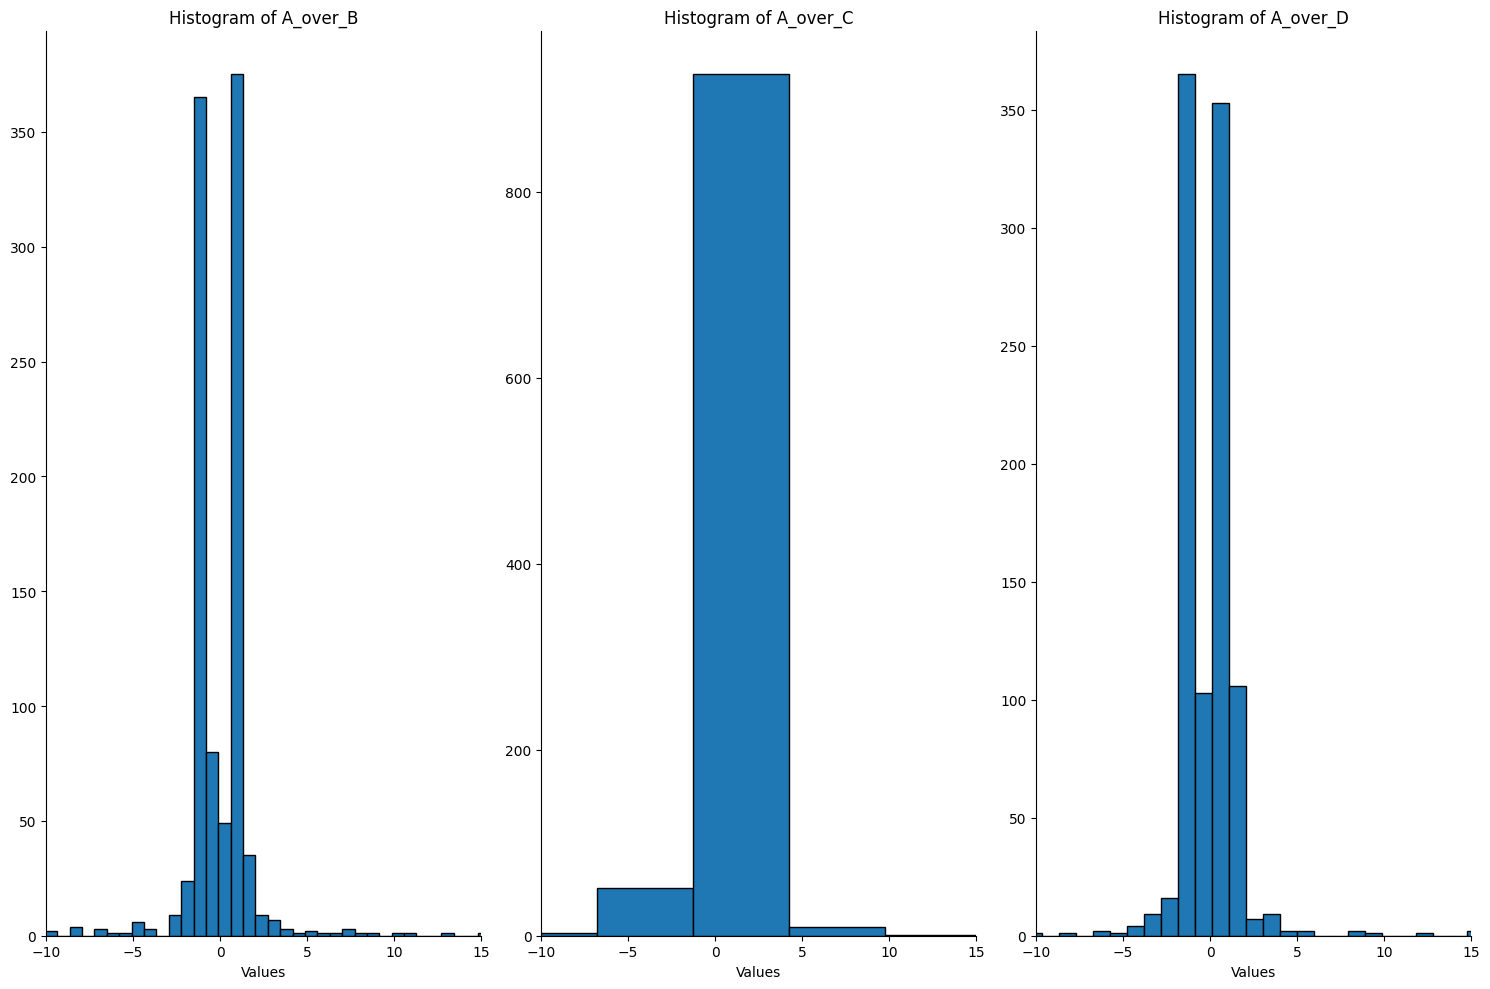

In [ ]:
# Histogram of the first 3 columns of the angle_ratios3_df

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

for i in range(3):
  axes[i].hist(angle_ratios3_df.iloc[:, i], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_title(f"Histogram of {angle_ratios3_df.columns[i]}")
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-10, 15)

plt.tight_layout()
plt.show()

## slope_differences3_df

In [ ]:
print("slope_differences3: head")
slope_differences3_df.head()

slope_differences3: head


,A_minus_B,A_minus_C,A_minus_D,B_minus_A,B_minus_C,B_minus_D,C_minus_A,C_minus_B,C_minus_D,D_minus_A,D_minus_B,D_minus_C
0,0.757086,0.912507,1.345351,-0.757086,0.155421,0.588265,-0.912507,-0.155421,0.432845,-1.345351,-0.588265,-0.432845
1,0.000016,0.050478,0.441743,-0.000016,0.050462,0.441727,-0.050478,-0.050462,0.391265,-0.441743,-0.441727,-0.391265
2,-0.284183,-0.669445,-0.433882,0.284183,-0.385261,-0.149699,0.669445,0.385261,0.235562,0.433882,0.149699,-0.235562
3,0.449006,0.425921,0.427007,-0.449006,-0.023086,-0.022000,-0.425921,0.023086,0.001086,-0.427007,0.022000,-0.001086
4,-5.414166,1.140574,-0.037887,5.414166,6.554741,5.376279,-1.140574,-6.554741,-1.178461,0.037887,-5.376279,1.178461


In [ ]:
# Mean, standard deviation and percentage of values under 1 standard deviation from the mean

slope_differences3_df_mean_std = pd.DataFrame(columns=['Mean', 'Std'])
slope_differences3_df_mean_std['Mean'] = slope_differences3_df.mean()
slope_differences3_df_mean_std['Std'] = slope_differences3_df.std()

for column in slope_differences3_df_mean_std.index:
  mean = slope_differences3_df_mean_std.loc[column, 'Mean']
  std = slope_differences3_df_mean_std.loc[column, 'Std']
  slope_differences3_df_mean_std.loc[column, '1 std'] = len(slope_differences3_df[column][(slope_differences3_df[column] >= mean - 1*std) & (slope_differences3_df[column] <= mean + 1*std)])/len(slope_differences3_df[column])*100

print(slope_differences3_df_mean_std)

               Mean        Std  1 std
A_minus_B -0.207100   8.100811   97.0
A_minus_C -0.542764  14.625779   98.3
A_minus_D  0.150836   9.043770   97.1
B_minus_A  0.207100   8.100811   97.0
B_minus_C -0.335664  12.607299   98.5
B_minus_D  0.357936   5.265866   95.3
C_minus_A  0.542764  14.625779   98.3
C_minus_B  0.335664  12.607299   98.5
C_minus_D  0.693600  13.232397   98.3
D_minus_A -0.150836   9.043770   97.1
D_minus_B -0.357936   5.265866   95.3
D_minus_C -0.693600  13.232397   98.3


In [ ]:
# put min and max values for each column in a data frame

slope_differences3_df_min_max = pd.DataFrame(columns=['Min', 'Max'])
slope_differences3_df_min_max['Min'] = slope_differences3_df.min()
slope_differences3_df_min_max['Max'] = slope_differences3_df.max()
print(slope_differences3_df_min_max)

                  Min         Max
A_minus_B -191.392157   74.524747
A_minus_C -380.799523   74.525802
A_minus_D -191.289533  103.070821
B_minus_A  -74.524747  191.392157
B_minus_C -381.142895   62.951425
B_minus_D  -50.587804  106.332042
C_minus_A  -74.525802  380.799523
C_minus_B  -62.951425  381.142895
C_minus_D  -62.357169  381.499990
D_minus_A -103.070821  191.289533
D_minus_B -106.332042   50.587804
D_minus_C -381.499990   62.357169


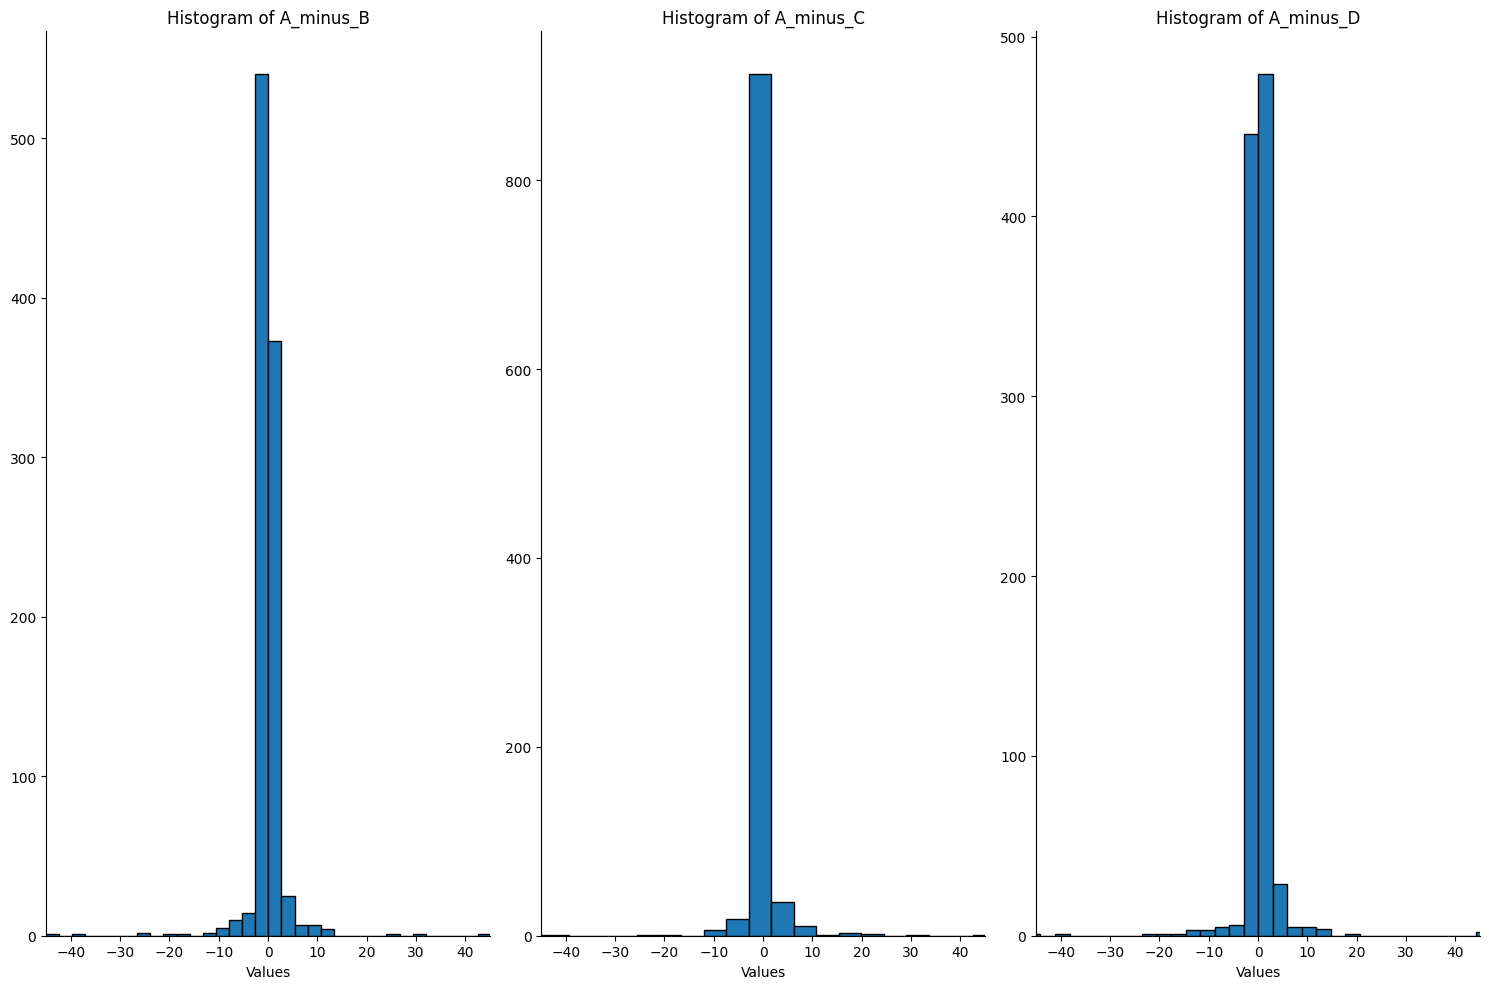

In [ ]:
# Histogram of the first 3 columns of the slope_differences3_df

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,10))

for i in range(3):
  axes[i].hist(slope_differences3_df.iloc[:, i], bins=100, edgecolor='black')
  axes[i].set_xlabel('Values')
  axes[i].set_title(f"Histogram of {slope_differences3_df.columns[i]}")
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_xlim(-45, 45)

plt.tight_layout()
plt.show()